In [ ]:
%pip install pot tqdm ultralytics opencv-python supervision pandas scikit-learn numba

In [31]:
##################
##### Import #####
##################
# Pandas
import pandas as pd
# Numpy
import numpy as np
# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from matplotlib.font_manager import FontProperties
import matplotlib.patches as patches
import matplotlib.cm as cm
# Scikit learn
from sklearn.cluster import DBSCAN, KMeans
# Scipy
from scipy.spatial import ConvexHull
# Math
import math
# Tqdm
from tqdm import tqdm
# time
import time
# ot
import ot
# tqdm
from tqdm import tqdm
# numba
from numba import jit
# pickle
import pickle
# YOLO
from ultralytics import YOLO
# OpenCV
import cv2
# Supervision
import supervision as sv
# Requests
import requests
# Io
from io import BytesIO
# PIL
from PIL import Image, ImageDraw, ImageFont, ImageFilter
# Scipy
from scipy.stats import norm
from scipy.interpolate import interp1d

#######################
##### Set options #####
#######################

# Set pandas options
pd.set_option('display.max_columns', None)
# Custom font
custom_font = FontProperties(fname="data/fonts/unicode.clarendb.ttf")
roboto_bold_path = "data/fonts/Roboto-Bold.ttf"
nabla_path = "data/fonts/Nabla-Regular-VariableFont_EDPT,EHLT.ttf"
# Set matplotlib options
plt.rc("animation", html="html5")
# Create a new colormap
colors = [(0, 'green'), (0.5, 'yellow'), (1.0, 'red')]
gyr_cmap = mcolors.LinearSegmentedColormap.from_list(
    'RdYlGn_Custom_Saturated',
    colors,
    N=256
)

In [33]:
# Custom font
custom_font = FontProperties(fname="data/fonts/unicode.clarendb.ttf")
roboto_bold_path = "data/fonts/Roboto-Bold.ttf"
nabla_path = "data/fonts/Nabla-Regular-VariableFont_EDPT,EHLT.ttf"

# Import and transform the data

In this section, we first import the data and in a second time we transform it in order to add supplementary information for further analysis.

## Import the data

We import data from two different sources:
- **Competition data**: NFL data provided on [Kaggle](https://www.kaggle.com/competitions/nfl-big-data-bowl-2026-analytics/overview) for the competition.
- **Pro Football Reference data**: NFL data form the [Pro Football Reference](https://www.pro-football-reference.com/) Website.

### Competition data (Kaggle)

The competition's data is composed of:
- `input_data`: tracking data before the pass is landed
- `output_data`: tracking data after the pass has been landed
- `supplementary_data`: data about each play

In [12]:
#######################################
##### KAGGLE / BIG DATA BOWL DATA #####
#######################################
# List of weeks
nfl_weeks = ["0{}".format(i) for i in range(1,10)] + [str(i) for i in list(range(10,19))]
# Input data
input_data = pd.concat([pd.read_csv("data/train/input_2023_w{}.csv".format(i)) for i in nfl_weeks]).reset_index(drop=True)
# Output data
output_data = pd.concat([pd.read_csv("data/train/output_2023_w{}.csv".format(i)) for i in nfl_weeks]).reset_index(drop=True)
# Supplementary data
supplementary_data = pd.read_csv("data/supplementary_data.csv", low_memory=False)

### Pro Football Reference data

From Pro Football Reference's data, we create ratings for each defensive players. These ratings are made from an R script and the [nflfastR](https://nflfastr.com/) package.

We also create a correspondance table to make the link between the `nfl_id` from the kaggle data and the `player_id` from Pro Football Reference. This data will allow us to add the ratings of the players to the input and output data.

In [13]:
#######################################
##### PRO FOOTBALL REFERENCE DATA #####
#######################################
# Player's rating
players_rating = pd.read_csv("data/players_rating.csv")
players_rating = players_rating.drop(columns=["Unnamed: 0"])
# Ids correspondance table
players_ids = pd.read_csv("data/players_ids.csv", delimiter=";")
players_ids = players_ids.drop(columns=["Unnamed: 0"])

## Transform the data

We transform the data in order to add the defender's rating to the `input_data` and `output_data` dataframes.

### Add player's team name to the data

In order to add the defensive player's ratings, we need to add their team's name. This will allow us to make the merge not only on the player's id but also on its team name. The rating evolove at each game of the season and on top of that, a player can play for more than one team during a season. That's why the player's team name is important in our data.

In [14]:
# Offensive team's names for each play
off_teams_names = supplementary_data[["game_id", "play_id", "possession_team", "week"]]
off_teams_names.loc[:,("player_side")] = "Offense"
off_teams_names.columns = ["game_id", "play_id", "team_name", "week", "player_side"]

# Defensive team's names for each play
def_teams_names = supplementary_data[["game_id", "play_id", "defensive_team", "week"]]
def_teams_names.loc[:,("player_side")] = "Defense"
def_teams_names.columns = ["game_id", "play_id", "team_name", "week", "player_side"]

# Concat the two dataframes ('off_teams_names' and 'def_teams_names')
teams_names = pd.concat([off_teams_names, def_teams_names]).reset_index(drop=True)

# Add the team's name to 'input_data'
input_data = pd.merge(input_data, teams_names, on=["game_id", "play_id", "player_side"], how="left")

# Add week nb + player's side and team name to 'output_data'
players_side_and_team = input_data[["game_id", "play_id", "nfl_id", "player_side", "team_name", "week"]].drop_duplicates().reset_index(drop=True)
# Add the player side and team name to 'output_data'
output_data = pd.merge(output_data, players_side_and_team, on=["game_id", "play_id", "nfl_id"], how="left")

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Add player's Pro Football Reference ids to the data

In [15]:
# Add PFR ids to 'input_data'
input_data = pd.merge(input_data, players_ids[["nfl_id", "player_id"]].drop_duplicates().reset_index(drop=True),
                      on="nfl_id", how="left")
# Add PFR ids to 'output_data'
output_data = pd.merge(output_data, players_ids[["nfl_id", "player_id"]].drop_duplicates().reset_index(drop=True),
                       on="nfl_id", how="left")

### Add player's ratings to the data

In [16]:
# Merge input data with players rating
input_data = pd.merge(input_data, players_rating[["week", "team", "player_id",
                                                  "performance_score", "headshot_url"]],
                      how="left", left_on=["week", "team_name", "player_id"],
                      right_on=["week", "team", "player_id"])

# Replace NA perf scores
input_data["performance_score"] = input_data["performance_score"].fillna(
    np.mean(input_data["performance_score"]))

# Merge output data with players rating
output_data = pd.merge(output_data, players_rating[["week", "team", "player_id",
                                                  "performance_score", "headshot_url"]],
                       how="left", left_on=["week", "team_name", "player_id"],
                       right_on=["week", "team", "player_id"])
output_data["performance_score"] = output_data["performance_score"].fillna(
    np.mean(output_data["performance_score"]))

# General functions

The functions created bellow will be used in the different sections that follows. Here are the different functions and their role:

- `get_play_data`: Allows us to get **input**, **output**, **input+output** and **supplementary** data for a play from a game. The function take the `game_id` and `play_id` as inputs.

- `draw_field`: Allows us to dra an NFL field for visualization. The function take the axis of the plot as input.

- `plot_frame`: Allows to visualize the data of a frame on a 2D format. The function take the axis of the plot and the tracking data of the frame as input.

- `create_animation`: Allows us to visualize a play in a 2D video format. The function take as input the `game_id` and `play_id` of the play.

In [17]:
################################################################################
################################ get_play_data #################################
################################################################################

def get_play_data(game_id, play_id):

  #############################
  ##### Play's input data #####
  #############################
  play_input_data = input_data[
      (input_data["game_id"]==game_id) &
       (input_data["play_id"]==play_id)
       ].reset_index(drop=True)
  # Add if the frame is in input and output
  play_input_data["input_output"] = "input"

  ##############################
  ##### Play's output data #####
  ##############################
  play_output_data = output_data[
      (output_data["game_id"]==game_id) &
       (output_data["play_id"]==play_id)
       ].reset_index(drop=True)
  # Add if the frame is in input and output
  play_output_data["input_output"] = "output"

  #################################################
  ##### Play's input and output combined data #####
  #################################################

  # Change the frame index in output data
  input_frame_nb = int(max(play_input_data["frame_id"]))
  play_output_for_merge_data = play_output_data.copy()
  play_output_for_merge_data["frame_id"] = play_output_for_merge_data["frame_id"] + input_frame_nb

  # Add input info to output dataframe
  play_input_for_merge_data = play_input_data[["player_to_predict",
                                               "nfl_id", "play_direction",
                                               "absolute_yardline_number",
                                               "player_name", "player_height",
                                               "player_weight",
                                               "player_birth_date",
                                               "player_position",
                                               "player_role",
                                               "num_frames_output",
                                               "ball_land_x",	"ball_land_y"]
                                              ].drop_duplicates()
  play_output_for_merge_data = pd.merge(play_input_for_merge_data,
                                        play_output_for_merge_data, how="right",
                                        on=["nfl_id"]).reset_index(drop=True)
  # Merge input and output dataframes
  play_input_output_data = pd.concat([play_input_data,
                                      play_output_for_merge_data],
                                     ignore_index=True, sort=False)


  #####################################
  ##### Play's supplementary data #####
  #####################################
  play_supplementary_data = supplementary_data[
      (supplementary_data["game_id"]==game_id) &
       (supplementary_data["play_id"]==play_id)
       ].reset_index(drop=True)

  ##################
  ##### RETURN #####
  ##################
  return {"input":play_input_data, "output":play_output_data,
          "input_output":play_input_output_data,
          "supplementary":play_supplementary_data}

################################################################################
################################## draw_field ##################################
################################################################################

def draw_field(ax):
    ax.set_axis_off()

    ax.fill([0,0,120,120],[0,53.3,53.3,0], color="green", zorder=0)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for x in range(0, 121, 10):
            ax.axvline(x, color='white', zorder=0)

    for x in range(10, 111, 1):
            ax.plot([x, x], [0,1], color="white", zorder=0)
            ax.plot([x, x], [53.3-1.1,53.3], color="white", zorder=0)
            ax.plot([x, x], [18.25-0.33, 18.25+0.33], color="white", zorder=0)
            ax.plot([x, x], [53.3-18.25+0.33, 53.3-18.25-0.33], color="white", zorder=0)

    for i, j in zip([1, 2, 3, 4, 5, 4, 3, 2, 1],
     [20, 30, 40, 50, 60, 70, 80, 90, 100]) :
        ax.text(j-2.5, 8, str(i), color="white", fontsize=25,
                fontproperties=custom_font, zorder=0)
        ax.text(j+0.5, 8, "0", color="white", fontsize=25,
                fontproperties=custom_font, zorder=0)
        ax.text(j+0.5, 53.3-10, str(i), color="white", fontsize=25,
                fontproperties=custom_font, rotation=180, zorder=0)
        ax.text(j-3, 53.3-10, "0", color="white", fontsize=25,
                fontproperties=custom_font, rotation=180, zorder=0)

    for i in [20,30,40,50] :
        ax.fill([i-3.5, i-4.5, i-3.5], [8.9, 9.2, 9.5], alpha=1, color='white', zorder=0)
        ax.fill([i-3.5, i-4.5, i-3.5], [53.3-9.5, 53.3-9.7, 53.3-10], alpha=1,
                color='white', zorder=0)

    for i in [70, 80, 90, 100] :
        ax.fill([i+3.5, i+4.5, i+3.5], [8.9, 9.2, 9.5], alpha=1, color='white', zorder=0)
        ax.fill([i+3.5, i+4.5, i+3.5], [53.3-9.5, 53.3-9.7, 53.3-10], alpha=1,
                color='white', zorder=0)

################################################################################
################################## plot_frame ##################################
################################################################################

def plot_frame(ax, data):
  # fig, ax = plt.subplots(figsize=(8,8))
  ax.clear()
  draw_field(ax)

  # Get the colors
  for i in range(len(data)):
    # Set the color
    if data.loc[i, "player_side"] == "Offense":
      color = "red"
    else:
      color = "blue"
    # Plot the player
    if data.loc[i, "player_to_predict"] == True:
      ax.scatter(data.loc[i, "x"], data.loc[i, "y"], c=color, s=50,
                edgecolors='black', linewidths=2, zorder=3)
    else:
      ax.scatter(data.loc[i, "x"], data.loc[i, "y"], c=color, s=50, zorder=3)
  # Plot the ball land
  ax.scatter(data.loc[0, "ball_land_x"], data.loc[0, "ball_land_y"], c="black",
             s=50)

  # Set the x and y limits
  x_mean = np.mean(data[data["player_to_predict"]==True]["x"])
  y_mean = np.mean(data[data["player_to_predict"]==True]["y"])
  ax.set_xlim(x_mean-20, x_mean+20)
  ax.set_ylim(y_mean-20, y_mean+20)

################################################################################
############################### create_animation ###############################
################################################################################

def create_animation(game_id, play_id, interval=200):

  # Get the dataframe of the play
  play_input_output_data = get_play_data(game_id, play_id)["input_output"]

  # Create the animation
  fig, ax = plt.subplots(figsize=(8, 8))

  def update(frame_index):
    plot_frame(ax, play_input_output_data[
        play_input_output_data["frame_id"]==frame_index].reset_index(drop=True))

  ani = FuncAnimation(fig, update,
                      frames=list(pd.unique(play_input_output_data["frame_id"])),
                      interval=interval)

  plt.close()

  # RETURN
  return ani

# Idea description

Our idea is to transform the different players and the reception point into densities. When the different densities will be computed, we will try to apply the **Optimal Transport Theory** in order to create a metric.

Problematic:

**To what extent does the receiver's movement “stretch” the defense in space?**

## General functions - Idea description

We create different functions that will be used all along the 'Idea description' section. Here are those functions and their descriptions:

- `asymmetric_gaussian_2d_rotated`: Allows us to create an assymetric gaussian in two dimension and to rotate it. The densities created by this functions will corresponds to the defensive players. The function takes as input:
    - The `X` and `Y` coordinates of the grid.
    - The `mu_x` and `mu_y` coordinates that corresponds to the center of the density (here, the x and y location of the player)
    - The four sigma values of the density, `sigma_x_left`, `sigma_x_right`, `sigma_y_down` and `sigma_y_up`.
    - The rotation angle `theta` in radians.

- `gaussian_2d`: Allows us to create a two dimensions gaussian. The function takes as input:
    - The `grid_x` and `grid_y` coordinates of the grid.
    - The center/mean of the gaussian (`mu`)
    - The sigma/standard deviation value of the gaussian (`sigma`)

- `sinkhorn`: Allows us to compute the Sinkhorn distance between two densities, represented as grids, that solve the [optimal transport theory problem](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics)).

- `add_dir_rad_to_input_output_data`: Add the direction of the players based on their `x` and `y` coordinates throughout the play. The function takes as input the dataframe to which we want to add the directions of the players.

In [18]:
################################################################################
######################## asymmetric_gaussian_2d_rotated ########################
################################################################################

def asymmetric_gaussian_2d_rotated(X, Y, mu_x=0, mu_y=0,
                                   sigma_x_left=1.0, sigma_x_right=2.0,
                                   sigma_y_down=1.0, sigma_y_up=2.0,
                                   theta=0):

    """
    Creates an asymmetric 2D distribution with rotation.

    Parameters:
    - X, Y: meshgrid grids
    - mu_x, mu_y: distribution center
    - sigma_x_left, sigma_x_right: left and right standard deviations
    - sigma_y_down, sigma_y_up: standard deviations at the bottom and top
    - theta: angle of rotation in radians (counterclockwise)
    """

    # Step 1: Translate to center on the origin
    X_centered = X - mu_x
    Y_centered = Y - mu_y

    # Step 2: Apply the REVERSE rotation to return to the unturned reference point.
    # (we rotate the coordinates in the opposite direction to evaluate the function)
    cos_theta = np.cos(-theta)
    sin_theta = np.sin(-theta)

    X_rotated = cos_theta * X_centered - sin_theta * Y_centered
    Y_rotated = sin_theta * X_centered + cos_theta * Y_centered

    # Step 3: Evaluate the distribution in the rotated coordinate system
    Z = np.zeros_like(X)

    # Masks for dividing space (in the rotated coordinate system)
    left = X_rotated < 0
    right = X_rotated >= 0
    down = Y_rotated < 0
    up = Y_rotated >= 0

    # Lower left quadrant
    mask = left & down
    Z[mask] = np.exp(-0.5 * (
        (X_rotated[mask] / sigma_x_left)**2 +
        (Y_rotated[mask] / sigma_y_down)**2
    ))

    # Lower right quadrant
    mask = right & down
    Z[mask] = np.exp(-0.5 * (
        (X_rotated[mask] / sigma_x_right)**2 +
        (Y_rotated[mask] / sigma_y_down)**2
    ))

    # Upper left quadrant
    mask = left & up
    Z[mask] = np.exp(-0.5 * (
        (X_rotated[mask] / sigma_x_left)**2 +
        (Y_rotated[mask] / sigma_y_up)**2
    ))

    # Upper right quadrant
    mask = right & up
    Z[mask] = np.exp(-0.5 * (
        (X_rotated[mask] / sigma_x_right)**2 +
        (Y_rotated[mask] / sigma_y_up)**2
    ))

    return Z

################################################################################
################################## gaussian_2d #################################
################################################################################

def gaussian_2d(grid_x, grid_y, mu, sigma):
    dx = grid_x - mu[0]
    dy = grid_y - mu[1]
    return np.exp(-0.5 * (dx**2 + dy**2) / (sigma**2))

################################################################################
################################### sinkhorn ###################################
################################################################################

def sinkhorn(a, b, C, K, epsilon=0.05, niter=1000, tol=1e-9):
    n = a.size
    # K = np.exp(-C / epsilon)
    # K[K < 1e-300] = 1e-300
    u = np.ones(n)
    v = np.ones(n)
    for it in range(niter):
        u_prev = u.copy()
        u = a / (K.dot(v) + 1e-300)
        v = b / (K.T.dot(u) + 1e-300)
        if np.linalg.norm(u - u_prev, 1) < tol:
            break
    gamma = np.outer(u, v) * K
    return gamma

def sinkhorn_optimized(a, b, C, K, epsilon=0.05, niter=1000, tol=1e-9):
    n = a.size

    u = np.ones(n)
    v = np.ones(n)

    # Pré-allouer les tableaux temporaires
    Kv = np.empty(n)
    KTu = np.empty(n)

    for it in range(niter):
        u_prev = u.copy()

        # Utiliser des opérations en place
        np.dot(K, v, out=Kv)
        Kv += 1e-300
        u = a / Kv

        np.dot(K.T, u, out=KTu)
        KTu += 1e-300
        v = b / KTu

        # Convergence check plus rapide
        if np.abs(u - u_prev).sum() < tol:
            break

    gamma = np.outer(u, v) * K
    return gamma

@jit(nopython=True)
def sinkhorn_fast(a, b, C, K, epsilon=0.05, niter=1000, tol=1e-9):
    n = a.size

    u = np.ones(n)
    v = np.ones(n)

    for it in range(niter):
        u_prev = u.copy()
        u = a / (K @ v + 1e-300)
        v = b / (K.T @ u + 1e-300)

        if np.sum(np.abs(u - u_prev)) < tol:
            break

    return np.outer(u, v) * K

################################################################################
####################### add_dir_rad_to_input_output_data #######################
################################################################################

def add_dir_rad_to_input_output_data(input_output_data):
  dir_data = pd.DataFrame()
  ind = 0
  for id in pd.unique(input_output_data["nfl_id"]):
    # Get player's data for the action
    action_player_data = input_output_data[input_output_data["nfl_id"]==id
                                              ].sort_values('frame_id'
                                              ).reset_index(drop=True)
    # Iterate on the frames
    for i in range(1,len(action_player_data)):
      dir_data.loc[ind, "frame_id"] = action_player_data.loc[i, "frame_id"]
      dir_data.loc[ind, "nfl_id"] = id
      dir_data.loc[ind, "radians_angle"] = np.arctan2(
          action_player_data.loc[i,"y"]- action_player_data.loc[i-1,"y"],
          action_player_data.loc[i,"x"]- action_player_data.loc[i-1,"x"])
      ind += 1

  # Merge
  input_output_data = pd.merge(input_output_data, dir_data,
                               on=["frame_id", "nfl_id"], how="left")

  # RETURN
  return input_output_data

## Get the data for the frame of a play

Here, we create a function that provides different types of data for a selected frame of a play. The function takes as input `play_data` which is the data from a play (one of the dataframe form the `get_play_data` function). The second argument that this function takes is `frame_id` which is the id of the frame wanted in the play. This function returns the following data:
- `play_data_frame`: Full data of the selected frame.
- `play_data_frame_offense`: Offense data of the selected frame.
- `play_data_frame_defense`: Defense data of the selected frame.
- `x_mean` & `y_mean`: The mean x and y coordiantes of the players in the frame.

In [19]:
def get_play_frame_data(play_data, frame_id, get_close_defenders_only=False,
                        get_close_defenders_to_rec=False):

  ############################################
  ##### DEFENDERS CLOSE TO LANDING POINT #####
  ############################################

  # Select only the close defenders (if 'get_close_defenders_only = True')
  if get_close_defenders_only == True:
    # Retrieve the last frame of the play
    play_frames = list(pd.unique(play_data["frame_id"]))
    play_frames.sort()
    last_frame = play_frames[-1]

    # Get last frame's data
    last_frame_data = play_data[
        (play_data["frame_id"]==last_frame) &
         (play_data["player_side"]=="Defense")].reset_index(drop=True)

    # Add distance to landing point
    last_frame_data["dist_to_landing_point"] = [math.sqrt(
        (last_frame_data.loc[i,"x"] - last_frame_data.loc[i,"ball_land_x"])**2 +
         (last_frame_data.loc[i,"y"] - last_frame_data.loc[i,"ball_land_y"])**2
        ) for i in range(len(last_frame_data))]

    # Select only the players that are ending less than five yards around the landing point
    selected_players = list(
        last_frame_data[last_frame_data["dist_to_landing_point"]<=5]["nfl_id"])

    # Select the desired players in 'play_data'
    play_data = play_data[(play_data["nfl_id"].isin(selected_players)) |
     (play_data["player_side"]=="Offense")].reset_index(drop=True)

  #######################################
  ##### DEFENDERS CLOSE TO RECEIVER #####
  #######################################

  if get_close_defenders_to_rec == True:
    # Set up the list
    players_close_to_reic = {}

    # Get the frames
    play_frames = list(pd.unique(play_data["frame_id"]))
    play_frames.sort()

    # Iterate on the frames
    for frame in play_frames:

      # Get frame's data
      frame_data = play_data[
          (play_data["frame_id"]==frame)].reset_index(drop=True)

      # Get the receiver's location on the frame
      receiver_data = frame_data[
          (frame_data["player_side"]=="Offense")].reset_index(drop=True)
      receiver_loc_x = receiver_data.loc[0,"x"]
      receiver_loc_y = receiver_data.loc[0,"y"]

      # Get defenders data
      defenders_data = frame_data[
          (frame_data["player_side"]=="Defense")].reset_index(drop=True)

      # Compute the distance to the receiver on the frame
      defenders_data["dist_to_receiver"] = [math.sqrt(
            (defenders_data.loc[i,"x"] - receiver_loc_x)**2 +
            (defenders_data.loc[i,"y"] - receiver_loc_y)**2
            ) for i in range(len(defenders_data))]

      # Get the close defenders on the frame
      frame_close_defenders = list(
          defenders_data[(defenders_data["dist_to_receiver"]<=5)]["nfl_id"])
      # Add the close defenders to the list
      if len(frame_close_defenders) > 0 :
        for id in frame_close_defenders:
          if id not in players_close_to_reic.keys():
            players_close_to_reic[id] = 1
          else:
            players_close_to_reic[id] += 1

    # Keep only the defender whno is the closest during all the play
    players_close_to_reic = dict(
        sorted(players_close_to_reic.items(), key=lambda x: x[1], reverse=True))
    if len(players_close_to_reic) == 0:
      return None
    closest_def = list(players_close_to_reic.keys())[0]

    # Filter the data
    play_data = play_data[
        (play_data["nfl_id"]==closest_def)|
        (play_data["player_side"]=="Offense")].reset_index(drop=True)

  ##############################
  ##### OTHER COMPUTATIONS #####
  ##############################

  # Get frame data
  play_data_frame = play_data[
      (play_data["frame_id"]==frame_id)&
        (play_data["player_to_predict"]==True)
       ].reset_index(drop=True)

  # Get offense data
  play_data_frame_offense = play_data_frame[
      (play_data_frame["player_side"]=="Offense")
      ].reset_index(drop=True)

  # Get defense data
  play_data_frame_defense = play_data_frame[
      (play_data_frame["player_side"]=="Defense")
      ].reset_index(drop=True)

  # Get the center of the axis in the play
  x_mean = int(np.mean(play_data_frame["x"]))
  y_mean = int(np.mean(play_data_frame["y"]))

  # Center the data in x, y = (0, 0)
  play_data_frame_offense["x"] = play_data_frame_offense["x"] - x_mean
  play_data_frame_offense["y"] = play_data_frame_offense["y"] - y_mean
  play_data_frame_defense["x"] = play_data_frame_defense["x"] - x_mean
  play_data_frame_defense["y"] = play_data_frame_defense["y"] - y_mean

  # RETURN
  return {"play_data_frame":play_data_frame,
          "play_data_frame_offense":play_data_frame_offense,
          "play_data_frame_defense": play_data_frame_defense,
          "x_mean":x_mean, "y_mean":y_mean}

In [20]:
################
##### TEST #####
################

# get the data for a play
game_id_test = 2023102204
play_id_test = 3849

# Get play data
play_data_test = get_play_data(game_id_test, play_id_test)
# Get play output data
play_data_output_test = play_data_test["input_output"]
# Add the player's directions to the data
play_data_output_test = add_dir_rad_to_input_output_data(play_data_output_test)
play_data_output_test = play_data_output_test[
    (~play_data_output_test["radians_angle"].isna())].reset_index(drop=True)
# Keep only output data
play_data_output_test = play_data_output_test[
    (play_data_output_test["input_output"]=="output")].reset_index(drop=True)

# Play frames
play_frames_test = list(pd.unique(play_data_output_test["frame_id"]))
play_frames_test.sort()

# Get play frame data
play_frame_data_test = get_play_frame_data(play_data_output_test,
                                           play_frames_test[0],
                                           get_close_defenders_to_rec=True)

# Get the different datasets
play_data_frame_test = play_frame_data_test["play_data_frame"]
play_data_frame_offense_test = play_frame_data_test["play_data_frame_offense"]
play_data_frame_defense_test = play_frame_data_test["play_data_frame_defense"]

## Set the grid

We create a grid that will contain the densities. This grid allows to structure the 'environment' to better compute the optimal transport. We define a grid of 50x50 small squares. Overall the grid contains 2500 small squares. We center the grid on the point (0,0).

In [21]:
# We set up the granularity
G = 2
# Number of grid points on the X axis
grid_size_x = 25*G
# Number of grid points on the Y axis
grid_size_y = 25*G

# We set the X min and X max values
x_min, x_max = -12.5, 12.5
# We set the Y min and Y max values
y_min, y_max = -12.5, 12.5

# From the values above we compute all the xs and ys points
xs = np.linspace(x_min, x_max, grid_size_x) # 50 points (x coordiantes)
ys = np.linspace(y_min, y_max, grid_size_y) # 50 points (y coordinates)

# We compute X and Y
X, Y = np.meshgrid(xs, ys) # X: 50 rows (x) of 50 points (y), Y: 50 columns (y) of 50 points (x)

# We compute all the points of the grid
points = np.stack([X.ravel(), Y.ravel()], axis=1) # 2500 points with x & y coords
# Number of 'squares' N
N = points.shape[0]

## Create the densities

In [22]:
def get_play_frame_densities(pdfo, pdfd):

  """
  pdfo : play data framer offense
  pdfd : play data frame defense
  """

  # Get the centers for each player
  offense_centers = np.array(pdfo[["x", "y"]])
  defense_centers = np.array(pdfd[["x", "y"]])

  # We set the sigma (fro the offense player)
  sigma = 0.5
  # We set the weights for the offense
  offense_weights = np.array([1]*len(offense_centers))
  offense_weights = offense_weights/offense_weights.sum()
  # We set the weights for the defense
  defense_scores = np.array(pdfd["performance_score"])
  defense_weights = defense_scores/defense_scores.sum()
  # Get the defender's angles
  defense_angles = np.array(pdfd["radians_angle"])

  # Create offense densities
  densities_offense = np.zeros((grid_size_y, grid_size_x))
  for w, c in zip(offense_weights, offense_centers):
    densities_offense += w * gaussian_2d(X, Y, c, sigma)

  # Create defense densities
  densities_defense = np.zeros((grid_size_y, grid_size_x))
  for w, c, a in zip(defense_weights, defense_centers, defense_angles):
    score = w * defense_scores.sum()
    densities_defense += (1/len(defense_weights)) * asymmetric_gaussian_2d_rotated(X, Y, mu_x=c[0],
                                                            mu_y=c[1],
                                                            sigma_x_left=1,
                                                            sigma_x_right=1+((score/100)*3),
                                                            sigma_y_down=(1+((score/100)*3))/2,
                                                            sigma_y_up=(1+((score/100)*3))/2,
                                                            theta=a)

  # Keep only the relevant values
  # Offense
  densities_offense_values = np.sort(densities_offense.ravel().astype(np.float64))[-(25*len(offense_centers)):]
  densities_offense_values_trsh = min(densities_offense_values)
  densities_offense[densities_offense < densities_offense_values_trsh] = 0
  # Defense
  densities_defense_values = np.sort(densities_defense.ravel().astype(np.float64))[-(25*len(defense_centers)):]
  densities_defense_values_trsh = min(densities_defense_values)
  densities_defense[densities_defense < densities_defense_values_trsh] = 0

  # Standardisation
  densities_offense = densities_offense / densities_offense.sum()
  densities_defense = densities_defense / densities_defense.sum()

  offense = densities_offense.ravel().astype(np.float64)
  defense = densities_defense.ravel().astype(np.float64)

  # RETURN
  return {"densities_offense":densities_offense,
          "densities_defense":densities_defense,
          "offense":offense,
          "defense":defense}

In [23]:
################
##### TEST #####
################
# Get the play frame densities
test_get_play_frame_dens_test = get_play_frame_densities(
    play_data_frame_offense_test, play_data_frame_defense_test)
# Offense densities
densities_offense_test = test_get_play_frame_dens_test["densities_offense"]
# Defense densities
densities_defense_test = test_get_play_frame_dens_test["densities_defense"]
# Offense densities (flatten)
offense_test = test_get_play_frame_dens_test["offense"]
# Defense densities (flatten)
defense_test = test_get_play_frame_dens_test["defense"]

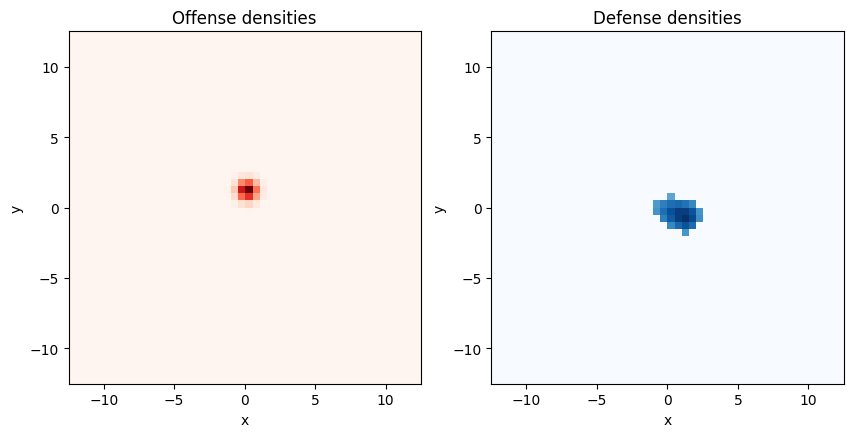

In [24]:
#######################################
##### REPRESENT FRAME'S DENSITIES #####
#######################################

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the offense densities
axs[0].set_title("Offense densities")
axs[0].imshow(densities_offense_test, extent=(x_min,x_max,y_min,y_max),
              origin='lower', cmap='Reds')
axs[0].set_xlabel("x"); axs[0].set_ylabel("y")

# Plot the defense densities
axs[1].set_title("Defense densities")
axs[1].imshow(densities_defense_test, extent=(x_min,x_max,y_min,y_max),
              origin='lower', cmap="Blues")
axs[1].set_xlabel("x"); axs[1].set_ylabel("y")

# Show the plot
plt.show()

## Apply the optimal transport theory (OTT)

Now that we have created and explained the different densities, we can compute the optimal transportation between them (offense and defense). This principal is  called the [optimal transport theory / transportation theory](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics)).

In [25]:
coords = points
# Build cost matrix (smaller)
C = np.sum((coords[:, None, :] - coords[None, :, :])**2, axis=2)
C = C / np.max(C)
# K
epsilon = 0.05
K = np.exp(-C / epsilon)
K[K < 1e-300] = 1e-300

In [27]:
def apply_OTT(offense, defense, niter=2000):
  epsilon = 0.05

  # start_time_gamma = time.time()
  gamma = sinkhorn(defense, offense, C, K, epsilon=epsilon, niter=niter, tol=1e-3)

  # start_time_mapped = time.time()
  mapped = (gamma.dot(coords)) / (defense[:, None] + 1e-300)

  # Compute transport cost
  Wcost = np.sum(gamma * C)
  # RETURN
  return {"gamma":gamma, "mapped":mapped, "cost":Wcost}

In [28]:
################
##### TEST #####
################
# Apply the OTT
test_apply_OTT = apply_OTT(offense_test, defense_test, niter=1000)
# Gamma value
gamma_test = test_apply_OTT["gamma"]
# Mapped value
mapped_test = test_apply_OTT["mapped"]
# Cost value
cost_test = test_apply_OTT["cost"]
print(f"Cost : {round(cost_test, 3)}")

Cost : 0.004


## Visualizations

In [29]:
def plot_densities(ax, pfd, pdfd, do, dd, d, mp, plt_small_arrows = False):

  # pfd : Play frame data
  # pdfd : play data frame defense
  # do : densities offense
  # dd : densities defense
  # d : defense
  # mp : mapped

  indices = np.where(d > 0)[0]

  #########################
  ##### ADD THE PITCH #####
  #########################
  ax.clear()
  draw_field(ax)

  ##########################
  ##### PLOT DENSITIES #####
  ##########################

  # Get x_mean and y_mean for the play
  play_x_mean = np.mean(pfd["x_mean"])
  play_y_mean = np.mean(pfd["y_mean"])

  # Set up the densities for the plot (Defense)
  densities_defense_plot = dd.copy()
  densities_defense_plot = densities_defense_plot.astype(float)
  masked_defense = np.ma.masked_where(densities_defense_plot == 0,
                                      densities_defense_plot)
  cmap_blues = matplotlib.colormaps["Blues"]
  cmap_blues.set_bad("none")
  im_dens_def = ax.imshow(masked_defense, extent=(x_min+play_x_mean,
                                                  x_max+play_x_mean,
                                                  y_min+play_y_mean,
                                                  y_max+play_y_mean),
                origin='lower', cmap=cmap_blues, zorder=2)

  # Set up the densities for the plot (Offense)
  densities_offense_plot = do.copy()
  densities_offense_plot = densities_offense_plot.astype(float)
  masked_offense = np.ma.masked_where(densities_offense_plot == 0,
                                      densities_offense_plot)
  cmap_reds = matplotlib.colormaps["Reds"]
  cmap_reds.set_bad("none")
  im_dens_off = ax.imshow(masked_offense, extent=(x_min+play_x_mean,
                                                  x_max+play_x_mean,
                                                  y_min+play_y_mean,
                                                  y_max+play_y_mean),
                origin='lower', cmap=cmap_reds, zorder=2)

  ##########################
  ##### ADD THE ARROWS #####
  ##########################

  arrows_df = pd.DataFrame()
  indx = 0
  for i in indices:
      x0, y0 = coords[i]
      x1, y1 = mp[i]
      # Add data to arrows_df
      arrows_df.loc[indx, "x0"] = x0+play_x_mean
      arrows_df.loc[indx, "y0"] = y0+play_y_mean
      arrows_df.loc[indx, "x1"] = x1+play_x_mean
      arrows_df.loc[indx, "y1"] = y1+play_y_mean
      indx += 1
      if plt_small_arrows == True:
        ax.arrow(x0+play_x_mean, y0+play_y_mean,
        (x1+play_x_mean)-(x0+play_x_mean), (y1+play_y_mean)-(y0+play_y_mean),
                head_width=0.06, length_includes_head=True, linewidth=0.1)

  # Plot a 'big' arrow for each player
  nb_players = len(pd.unique(pdfd["nfl_id"]))
  # Apply kmeans algorithm with the number of players
  kmeans = KMeans(n_clusters=nb_players, random_state=42, n_init=10)
  kmeans.fit(arrows_df)
  labels = kmeans.labels_
  arrows_df["player_cluster"] = labels
  arrows_df_gb = arrows_df.groupby('player_cluster')[
      ['x0', 'y0', 'x1', 'y1']].mean().reset_index()
  # Plot the 'big' arrows
  if plt_small_arrows == False:
    for i in range(len(arrows_df_gb)):
      ax.arrow(arrows_df_gb.loc[i,'x0'], arrows_df_gb.loc[i,'y0'],
                (arrows_df_gb.loc[i,'x1']-arrows_df_gb.loc[i,'x0'])*0.75,
                (arrows_df_gb.loc[i,'y1']-arrows_df_gb.loc[i,'y0'])*0.75,
                head_width=0.5, head_length=0.3, length_includes_head=True,
              linewidth=7, color="black", alpha=0.5, zorder=1)

  #######################
  ##### PLOT SETUPS #####
  #######################
  ax.set_title("Projection barycentrique du plan de transport\n(flèches: point source -> image moyenne)")
  ax.set_xlabel("x"); ax.set_ylabel("y")
  ax.set_xlim(x_min+play_x_mean, x_max+play_x_mean)
  ax.set_ylim(y_min+play_y_mean, y_max+play_y_mean)

  # plt.colorbar(label="densité source")

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
# Plot the play frame's densities
plot_densities(ax, play_frame_data_test, play_data_frame_defense_test,
               densities_offense_test, densities_defense_test, defense_test,
               mapped_test, plt_small_arrows = False)

In [35]:
# Info récapitulative
Wcost = np.sum(gamma_test * C)  # coût OT approximé (entropie non enlevée)
print(f"Coût OT approché (somme gamma * coût) = {Wcost:.6f}")

Coût OT approché (somme gamma * coût) = 0.003853


# OTT calculation for a play pipeline

In [36]:
# We chose a play (play_id) from a game (game_id)
game_id = 2023102204
play_id = 3849

# Set up play viz index
play_viz_dens_indexes = {}

# Get play data
play_data = get_play_data(game_id, play_id)

# Get play data output
play_data_output = play_data["input_output"]
# Add the player's directions to the data
play_data_output = add_dir_rad_to_input_output_data(play_data_output)
play_data_output = play_data_output[~play_data_output["radians_angle"].isna()].reset_index(drop=True)
# Select only output data
play_data_output = play_data_output[
    (play_data_output["input_output"]=="output")].reset_index(drop=True)

# # We define the throw frame id
# throw_frame_id = min(list(play_data_output[
#     (play_data_output["input_output"]=="output")
#     ].reset_index(drop=True)["frame_id"]))
# # We select the ten frames before the throw + the frames after the throw
# frames_before_throw = 10
# play_data_output = play_data_output[
#     (play_data_output["frame_id"]>=(throw_frame_id-frames_before_throw))
#     ].reset_index(drop=True)

# Play frames
play_frames = list(pd.unique(play_data_output["frame_id"]))
play_frames.sort()

costs_list = []

# We iterate on each frame
for frame_id in play_frames:

  play_viz_dens_indexes[frame_id] = {}

  ###############################################
  ##### GET THE DATA FOR THE SELECTED FRAME #####
  ###############################################
  # Get play frame data
  play_frame_data = get_play_frame_data(play_data_output, frame_id,
                                        get_close_defenders_to_rec=True)

  if play_frame_data == None:
    print("No close defenders.")
    break
  play_viz_dens_indexes[frame_id]["play_frame_data"] = play_frame_data

  # Get the different datasets
  play_data_frame = play_frame_data["play_data_frame"]
  play_data_frame_offense = play_frame_data["play_data_frame_offense"]
  play_data_frame_defense = play_frame_data["play_data_frame_defense"]
  play_viz_dens_indexes[frame_id]["play_data_frame_defense"] = play_data_frame_defense

  ######################################
  ##### GET / CREATE THE DENSITIES #####
  ######################################

  play_frame_dens = get_play_frame_densities(play_data_frame_offense,
                                                    play_data_frame_defense)
  densities_offense = play_frame_dens["densities_offense"]
  play_viz_dens_indexes[frame_id]["densities_offense"] = densities_offense
  densities_defense = play_frame_dens["densities_defense"]
  play_viz_dens_indexes[frame_id]["densities_defense"] = densities_defense
  offense = play_frame_dens["offense"]
  defense = play_frame_dens["defense"]
  play_viz_dens_indexes[frame_id]["defense"] = defense

  #####################
  ##### APPLY OTT #####
  #####################
  OTT = apply_OTT(offense, defense)
  cost = OTT["cost"]
  mapped = OTT["mapped"]
  play_viz_dens_indexes[frame_id]["mapped"] = mapped

  # Add the cost to list of costs
  costs_list.append(cost)

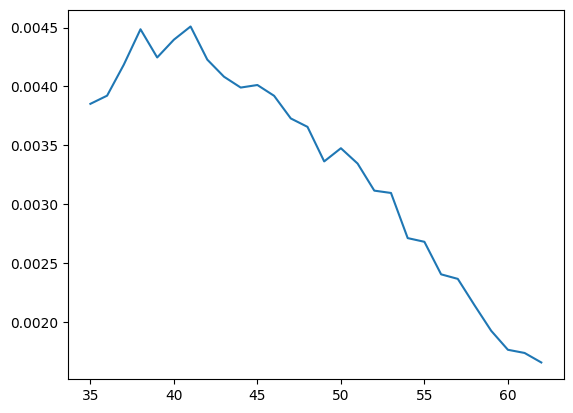

In [37]:
plt.plot(play_frames, costs_list)

## Create a function for the score

In [38]:
# Import the reference list of costs
file_name = "data/cost_list_reference.pkl"
with open(file_name, 'rb') as f:
  reference_cost_list = pickle.load(f)

# Calibrate ACI transformer
def calibrate_aci_transformer(W_distances_original):
  # 1 - Sort the W distances
  W_sorted = np.sort(W_distances_original)
  N = len(W_sorted)
  # 2 - Compute the rank (percentile P_i) (+0.5 to avoid 0 and 1 extremities)
  P_i = (np.arange(N)+0.5)/N
  # 3 - Reverse the percentile and transform into Z-score
  P_i_reverse = 1 - P_i
  Z_scores_calibrated = norm.ppf(P_i_reverse)
  # 4 - Create the interpolation function
  fonction_interp_z_score = interp1d(
        W_sorted,
        Z_scores_calibrated,
        kind='linear',
        fill_value="extrapolate" # Permet d'attribuer des scores aux valeurs extrêmes
    )
  # Return
  return fonction_interp_z_score, W_sorted

# Execute the calibration
Z_transformer, W_ref = calibrate_aci_transformer(reference_cost_list)

def compute_aci_score(W_new, Z_transformer=Z_transformer, W_ref_sorted=W_ref):

  # Deal with extreme values
  W_min_ref = W_ref_sorted[0]
  W_max_ref = W_ref_sorted[-1]

  # Apply the interpolation function
  Z_new = Z_transformer(W_new)

  MAX_Z_SCORE = norm.ppf(1 - (0.5/len(W_ref_sorted)))
  MIN_Z_SCORE = norm.ppf(0.5/len(W_ref_sorted))

  Z_new = np.clip(Z_new, MIN_Z_SCORE, MAX_Z_SCORE)

  # Final scaling
  ACI_score = 50 + (Z_new * 10)

  # Return
  return ACI_score

# Create a function to compute play inforamtions

In [39]:
def get_play_information(game_id, play_id, frames_before_throw = 10,
                         get_close_defenders_only=False,
                         get_close_defenders_to_rec=False):

  # Set up play viz index
  play_viz_dens_indexes = {}

  # Get play data
  play_data = get_play_data(game_id, play_id)

  # Get play data output
  play_data_output = play_data["input_output"]
  # Add the player's directions to the data
  play_data_output = add_dir_rad_to_input_output_data(play_data_output)
  play_data_output = play_data_output[~play_data_output["radians_angle"].isna()].reset_index(drop=True)

  # Keep only ontput data
  play_data_output = play_data_output[
      (play_data_output["input_output"]=="output")].reset_index(drop=True)

  # We check if there are at least one defender (if not, the result is null)
  defense_check_data = play_data_output[
      (play_data_output["player_side"]=="Defense") &
       (play_data_output["player_to_predict"]==True)].reset_index(drop=True)
  if len(defense_check_data) == 0:
    return None

  # Play frames
  play_frames = list(pd.unique(play_data_output["frame_id"]))
  play_frames.sort()

  costs_list = []

  # We iterate on each frame
  for frame_id in play_frames:

    play_viz_dens_indexes[frame_id] = {}

    # print(f"--------- Frame id: {frame_id} ---------")

    ###############################################
    ##### GET THE DATA FOR THE SELECTED FRAME #####
    ###############################################

    # Get play frame data
    play_frame_data = get_play_frame_data(play_data_output, frame_id,
                                          get_close_defenders_only=get_close_defenders_only,
                                          get_close_defenders_to_rec=get_close_defenders_to_rec)

    if play_frame_data == None:
      print("No close defenders.")
      return None

    # If no close player, we return 'None'
    if len(play_frame_data["play_data_frame_defense"]) == 0:
      return None

    play_viz_dens_indexes[frame_id]["play_frame_data"] = play_frame_data

    # Get the different datasets
    play_data_frame = play_frame_data["play_data_frame"]
    play_data_frame_offense = play_frame_data["play_data_frame_offense"]
    play_data_frame_defense = play_frame_data["play_data_frame_defense"]
    play_viz_dens_indexes[frame_id]["play_data_frame_defense"] = play_data_frame_defense

    ######################################
    ##### GET / CREATE THE DENSITIES #####
    ######################################

    play_frame_dens = get_play_frame_densities(play_data_frame_offense,
                                                      play_data_frame_defense)
    densities_offense = play_frame_dens["densities_offense"]
    play_viz_dens_indexes[frame_id]["densities_offense"] = densities_offense
    densities_defense = play_frame_dens["densities_defense"]
    play_viz_dens_indexes[frame_id]["densities_defense"] = densities_defense
    offense = play_frame_dens["offense"]
    defense = play_frame_dens["defense"]
    play_viz_dens_indexes[frame_id]["defense"] = defense

    #####################
    ##### APPLY OTT #####
    #####################

    # TIMER START - Apply OTT
    timer_start_apply_ott = time.time()

    OTT = apply_OTT(offense, defense, niter=500)

    # TIMER END - Apply OTT
    timer_end_apply_ott = time.time()

    # COMPUTE THE TOTAL TIME - Apply OTT
    total_time_apply_ott = timer_end_apply_ott - timer_start_apply_ott

    cost = OTT["cost"]
    mapped = OTT["mapped"]
    play_viz_dens_indexes[frame_id]["mapped"] = mapped

    # Add the cost to list of costs
    costs_list.append(cost)

  # Compute the stretch index
  stretch_index = compute_aci_score(costs_list)

  # Get receiver's name and team
  receiver_name = list(
      pd.unique(play_data_output[
          (play_data_output["player_side"]=="Offense")]["player_name"]))[0]

  # Get the defender's data
  defenders_data = play_data_frame_defense[
      ["player_name", "performance_score", "player_position", "headshot_url"]
        ].drop_duplicates().reset_index(drop=True)

  # Get the receiver's data
  receiver_data = play_data_output[
          (play_data_output["player_side"]=="Offense")]
  receiver_data = receiver_data[["player_name", "player_position"]
                                ].drop_duplicates().reset_index(drop=True)

  # RETURN
  return {"supplementary_data":play_data["supplementary"],
          "play_viz_dens_indexes": play_viz_dens_indexes,
          "cost_list": costs_list,
          "stretch_index": stretch_index,
          "receiver_data": receiver_data,
          "defenders_data": defenders_data,
          "nb_frames_input": len(pd.unique(play_data["input"]["frame_id"]))
          }

In [40]:
test = get_play_information(2023123106, 1453, get_close_defenders_to_rec=True)

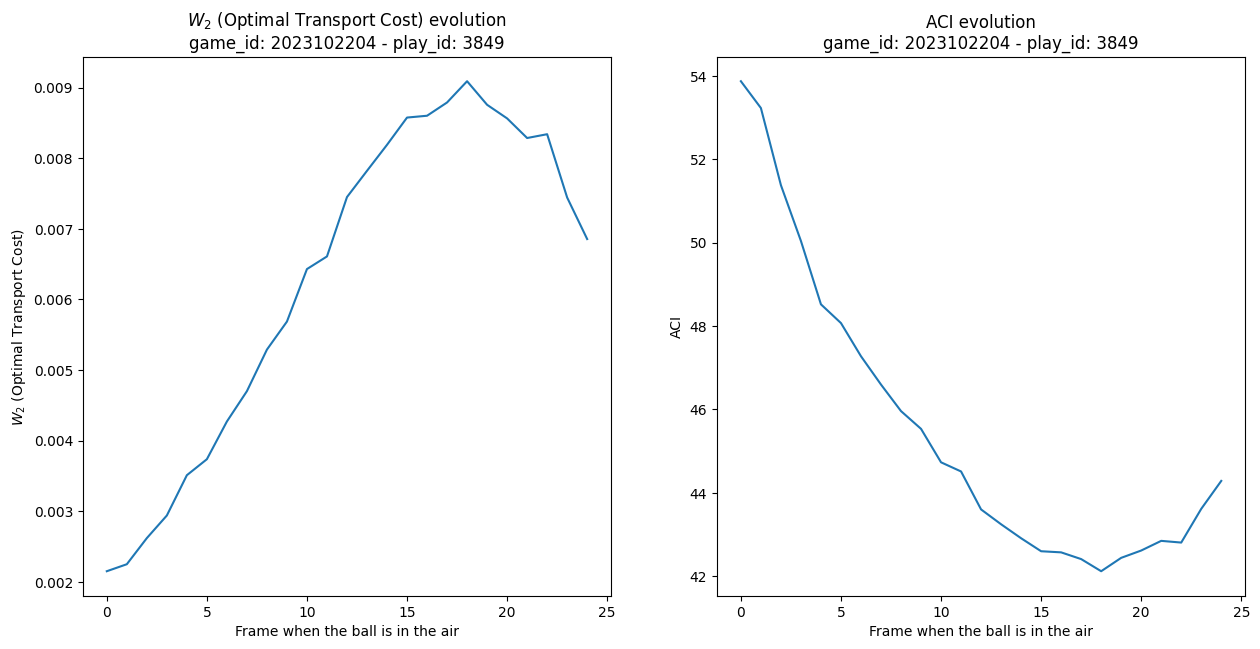

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the different scores
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# Cost
axs[0].plot(range(len(test["cost_list"])), test["cost_list"])
axs[0].set_title("$W_2$ (Optimal Transport Cost) evolution\ngame_id: 2023102204 - play_id: 3849")
axs[0].set_xlabel("Frame when the ball is in the air")
axs[0].set_ylabel("$W_2$ (Optimal Transport Cost)")
# Stretch Index
axs[1].plot(range(len(test["stretch_index"])), test["stretch_index"])
axs[1].set_title("ACI evolution\ngame_id: 2023102204 - play_id: 3849")
axs[1].set_xlabel("Frame when the ball is in the air")
axs[1].set_ylabel("ACI")
plt.show()
plt.tight_layout()
# fig.savefig('w2_aci_evol.jpg', dpi=500)

In [42]:
play_viz_dens_indexes = test["play_viz_dens_indexes"]

In [43]:
def create_density_animation(play_density_dict, interval=200):

  # Get the list of frames
  frames = list(play_density_dict.keys())
  frames.sort()

  # Create the animation
  fig, ax = plt.subplots(figsize=(8, 8))

  def update(frame_index):
    plot_densities(ax, play_density_dict[frame_index]["play_frame_data"],
                   play_density_dict[frame_index]["play_data_frame_defense"],
                   play_density_dict[frame_index]["densities_offense"],
                   play_density_dict[frame_index]["densities_defense"],
                   play_density_dict[frame_index]["defense"],
                   play_density_dict[frame_index]["mapped"],
                   plt_small_arrows = False)

  ani = FuncAnimation(fig, update,
                      frames=frames,
                      interval=interval)

  plt.close()

  # RETURN
  return ani

In [ ]:
create_density_animation(play_viz_dens_indexes, 100)

In [ ]:
create_animation(2023102205, 784, 100)

# Make the video

## Functions & variables

### Read and save the video

In [46]:
# Function to read the video
def read_video(video_path):
  cap = cv2.VideoCapture(video_path)
  frames = []
  while True:
    ret, frame = cap.read()
    if not ret:
      break
    frames.append(frame)
  return frames

# Function to save the video
def save_video(output_video_frames, output_video_path):
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(output_video_path, fourcc, 60,
   (output_video_frames[0].shape[1],output_video_frames[0].shape[0]))
  for frame in output_video_frames:
    # Write the frame t the video writer
    out.write(frame)
  out.release()

### Variables

In [47]:
# Color dictionnary
players_color = {
    "Offense": (0,0,255),
    "Defense": (255,0,0)
}

### Out of class functions

In [48]:
################################
##### CONVERT VALUE TO BGR #####
################################

def value_to_bgr(value, colormap_name='viridis', vmin=1, vmax=100):
    """
    Converts a numeric value (between vmin and vmax) into a BGR color tuple (0-255).
    """
    norm = (value - vmin) / (vmax - vmin) # 1. Normalize the value (0 to 1)
    cmap = cm.get_cmap(colormap_name) # 2. Apply the colormap
    rgba = cmap(norm) # (returns an RGBA tuple from 0.0 to 1.0)
    # 3. Convert to BGR (0-255, integer values)
    B = int(rgba[2] * 255)
    G = int(rgba[1] * 255)
    R = int(rgba[0] * 255)
    # 4. Return the BGR tuple
    return (B, G, R)

###################################
##### DOWNLOAD IMAGE FROM URL #####
###################################

def download_image_from_url(url):
    """
    Downloads an image from a URL and converts it to OpenCV format
    """
    try:
        # Download the image
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        # Convert to PIL image
        image_pil = Image.open(BytesIO(response.content))
        # Convert to RGB if necessary (remove the alpha channel if present)
        if image_pil.mode == 'RGBA':
            # Create a white background
            background = Image.new('RGB', image_pil.size, (255, 255, 255))
            background.paste(image_pil, mask=image_pil.split()[3])  # 3 is the alpha channel
            image_pil = background
        elif image_pil.mode != 'RGB':
            image_pil = image_pil.convert('RGB')
        # Convert into numpy array
        image_np = np.array(image_pil)
        # Convert RGB to BGR for OpenCV
        image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
        return image_bgr
    # Exception
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None

###################################
##### BBOX GEOMETRY FUNCTIONS #####
###################################

# Get bbox center
def get_center_of_bbox(bbox):
  x1,y1,x2,y2 = bbox
  return int((x1+x2)/2), int((y1+y2)/2)

# Get bbox width
def get_bbox_width(bbox):
  return bbox[2] - bbox[0]

# get bbox height
def get_bbox_height(bbox):
  return bbox[3] - bbox[1]

### Tracker

In [49]:
class Tracker:
  def __init__(self, model_path):
    self.model = YOLO(model_path)
    self.tracker = sv.ByteTrack()

  ##########################
  ###### DETECT FRAMES #####
  ##########################

  def detect_frames(self, frames):
    batch_size = 20
    detections = []
    for i in range(0, len(frames), batch_size):
      detections_batch = self.model.predict(frames[i:i+batch_size], conf=0.1)
      detections += detections_batch
    # Return
    return detections

  #############################
  ##### GET OBJECT TRACKS #####
  #############################

  def get_object_tracks(self, frames):
    # Detect the objects
    detections = self.detect_frames(frames)
    # Set up the 'tracks' dictionary
    tracks={"persons":[]}
    # Iterate on the frames
    for frame_num, detection in enumerate(detections):
      # Get class names
      cls_names = detection.names
      # Reverse the class names
      cls_names_inv = {v:k for k,v in cls_names.items()}
      # Convert to supervision Detection format
      detection_supervision = sv.Detections.from_ultralytics(detection)
      # Track objects
      detection_with_tracks = self.tracker.update_with_detections(
          detection_supervision)
      # Add a dictionary for the 'persons' keys in 'tracks'
      tracks["persons"].append({})
      # Iterate on the detected objects
      for frame_detection in detection_with_tracks:
        bbox = frame_detection[0].tolist() # Detected object's bbox
        cls_id = frame_detection[3] # Detected object's class id
        track_id = frame_detection[4] # Detected object's track id
        # Retrieve the segmentation mask if available
        mask = frame_detection[1] if frame_detection[1] is not None else None
        # Add the players (persons) to the tracks dictionary
        if cls_id == cls_names_inv["person"]:
          tracks["persons"][frame_num][track_id] = {"bbox":bbox, "mask": mask}
    # Return
    return tracks

  #############################################
  ##### DRAW TEXT WITH OUTLINE AND SHADOW #####
  #############################################

  def draw_text_with_outline_and_shadow(self, frame, text, position, font_path, font_size=20,
                                      text_color=(255, 255, 255), outline_color=(0, 0, 0),
                                      outline_width=2, shadow_color=(0, 0, 0),
                                      shadow_offset=(3, 3), shadow_blur=2,
                                      bg_color=None, padding=5):

    # Convertir BGR en RGB pour PIL
    text_color_rgb = (text_color[2], text_color[1], text_color[0])
    outline_color_rgb = (outline_color[2], outline_color[1], outline_color[0])
    shadow_color_rgb = (shadow_color[2], shadow_color[1], shadow_color[0])

    # Charger la police
    try:
        font = ImageFont.truetype(font_path, font_size)
    except:
        print(f"Impossible de charger la police {font_path}")
        font = ImageFont.load_default()

    # Calculer la taille du texte
    dummy_img = Image.new('RGBA', (1, 1))
    dummy_draw = ImageDraw.Draw(dummy_img)
    bbox = dummy_draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Créer une image temporaire avec transparence (plus grande pour l'ombre)
    extra_space = max(abs(shadow_offset[0]), abs(shadow_offset[1])) + shadow_blur + outline_width + padding * 2
    temp_width = text_width + extra_space * 2
    temp_height = text_height + extra_space * 2

    temp_image = Image.new('RGBA', (temp_width, temp_height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(temp_image)

    # Position du texte dans l'image temporaire (centré avec espace pour l'ombre)
    text_x = extra_space - bbox[0]
    text_y = extra_space - bbox[1]

    # 1. Dessiner l'ombre (si décalage non nul)
    if shadow_offset != (0, 0):
        shadow_x = text_x + shadow_offset[0]
        shadow_y = text_y + shadow_offset[1]

        # Créer une image séparée pour l'ombre
        shadow_image = Image.new('RGBA', (temp_width, temp_height), (0, 0, 0, 0))
        shadow_draw = ImageDraw.Draw(shadow_image)

        # Dessiner l'ombre
        shadow_draw.text((shadow_x, shadow_y), text, font=font, fill=shadow_color_rgb + (200,))

        # Appliquer le flou à l'ombre
        if shadow_blur > 0:
            shadow_image = shadow_image.filter(ImageFilter.GaussianBlur(radius=shadow_blur))

        # Composer l'ombre sur l'image temporaire
        temp_image = Image.alpha_composite(temp_image, shadow_image)

    # 2. Dessiner le contour (stroke)
    if outline_width > 0:
        draw.text((text_x, text_y), text, font=font, fill=outline_color_rgb,
                 stroke_width=outline_width, stroke_fill=outline_color_rgb)

    # 3. Dessiner le texte principal
    draw.text((text_x, text_y), text, font=font, fill=text_color_rgb)

    # 4. Ajouter un fond si spécifié
    if bg_color is not None:
        bg_color_rgb = (bg_color[2], bg_color[1], bg_color[0])
        bg_image = Image.new('RGBA', (temp_width, temp_height), bg_color_rgb + (255,))
        bg_image.paste(temp_image, (0, 0), temp_image)
        temp_image = bg_image

    # Convertir en OpenCV
    temp_array = np.array(temp_image)

    # Extraire le canal alpha
    alpha = temp_array[:, :, 3] / 255.0

    # Convertir RGBA en BGR
    temp_bgr = cv2.cvtColor(temp_array, cv2.COLOR_RGBA2BGR)

    # Position finale sur la frame
    x, y = position
    x_offset = x - extra_space
    y_offset = y - extra_space

    # S'assurer que l'image ne dépasse pas les limites
    frame_height, frame_width = frame.shape[:2]

    x_start = max(0, x_offset)
    y_start = max(0, y_offset)
    x_end = min(frame_width, x_offset + temp_width)
    y_end = min(frame_height, y_offset + temp_height)

    # Ajuster les indices pour l'image temporaire
    temp_x_start = x_start - x_offset
    temp_y_start = y_start - y_offset
    temp_x_end = temp_x_start + (x_end - x_start)
    temp_y_end = temp_y_start + (y_end - y_start)

    # Appliquer l'alpha blending
    roi = frame[y_start:y_end, x_start:x_end]
    temp_region = temp_bgr[temp_y_start:temp_y_end, temp_x_start:temp_x_end]
    alpha_region = alpha[temp_y_start:temp_y_end, temp_x_start:temp_x_end]

    blended = (roi * (1 - alpha_region[:, :, np.newaxis]) +
               temp_region * alpha_region[:, :, np.newaxis]).astype(np.uint8)

    frame[y_start:y_end, x_start:x_end] = blended

    return frame

  ########################################
  ##### DRAW ELLIPSES AROUND PLAYERS #####
  ########################################

  def draw_ellipse(self, frame, bbox, color, track_id, ellipse_size=1,
                   thickness=-1, get_players_ids=False, deport=0):
    """
    Function to draw ellipses under players
    """
    y2 = int(bbox[3]) # Get 'y2' point
    x_center, _ = get_center_of_bbox(bbox) # Get bbox's x center
    width = get_bbox_width(bbox) # get bbox's width

    # Draw the ellipse
    if get_players_ids == True:
      cv2.ellipse(frame, center=(x_center+deport, y2+deport),
                  axes = (int(160*ellipse_size), int(0.35*160*ellipse_size)),
                  angle=0.0, startAngle=45, endAngle=235, color = color,
                  thickness = thickness, lineType=cv2.LINE_4)
    else:
      cv2.ellipse(frame, center=(x_center+deport, y2+deport),
                  axes = (int(160*ellipse_size), int(0.35*160*ellipse_size)),
                  angle=0.0, startAngle=0, endAngle=360, color = color,
                  thickness = thickness, lineType=cv2.LINE_4)

    # If 'get_players ids == True' we display the tracks id alongside the ellipses
    if get_players_ids == True:
      # Add track_id
      text_track_id = f"ID: {track_id}"
      # text position
      text_track_id_x = x_center + 20
      text_track_id_y = y2 - int(0.35*width) - 10
      # Write the text
      cv2.putText(frame, text_track_id, (text_track_id_x, text_track_id_y),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
    # Return
    return frame

  #########################################
  ##### DRAW LINE BETWEEN TWO PLAYERS #####
  #########################################

  def draw_line(self, frame, bbox1, bbox2, color, linewidth=10, difference=0):
    """
    Function to draw a line (the connexion) between the WR and DB
    """
    # Get the centers
    x_center_1, y_center_1 = get_center_of_bbox(bbox1)
    x_center_2, y_center_2 = get_center_of_bbox(bbox2)
    # Get the heights
    bbox_1_height = get_bbox_height(bbox1)
    bbox_2_height = get_bbox_height(bbox2)
    # Draw the line
    cv2.line(frame, (x_center_1+difference, y_center_1+int(0.45*bbox_1_height)+difference),
     (x_center_2+difference, y_center_2+int(0.45*bbox_2_height)+difference), color=color,
             thickness=linewidth, lineType=cv2.LINE_AA)
    # Return
    return frame

  #################################
  ##### DRAW THE FRAME NUMBER #####
  #################################

  def draw_frame_number(self, frame, frame_number):
    """
    - Function to draw the frame number.
    - Allow the user to select the moment where the WR catches the ball.
    """
    cv2.putText(
          frame,
          str(frame_number),
          (100, 200),
          cv2.FONT_HERSHEY_SIMPLEX,
          3,  # Font size
          (0, 0, 0),  # Couleur blanche pour contraste
          2,  # Thikness
          cv2.LINE_AA  # Anti-aliasing pour un rendu plus lisse
      )
    # Return
    return frame

  ###################################
  ##### DRAW COLOR GRADIENT BAR #####
  ###################################

  def draw_color_gradient_bar(self, frame, colormap_name='hot', vmin=0, vmax=100,
                            current_value=None, bar_width=50, margin=20, position='right',
                            corner_radius=15, font_path=roboto_bold_path, font_size=30):
    """
    Ajoute une barre verticale avec un dégradé de couleur et des coins arrondis

    Args:
        corner_radius: Rayon des coins arrondis (en pixels)
    """
    frame_height, frame_width = frame.shape[:2]

    # Position de la barre
    if position == 'right':
        bar_x = frame_width - bar_width - 100
    else:
        bar_x = margin

    bar_y_start = margin
    bar_y_end = frame_height - margin
    bar_height = bar_y_end - bar_y_start

    # Créer une image temporaire pour la barre avec canal alpha
    bar_overlay = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

    # Créer le dégradé sur l'overlay
    cmap = cm.get_cmap(colormap_name)

    for i in range(bar_height):
        norm_value = 1 - (i / bar_height)
        rgba = cmap(norm_value)

        B = int(rgba[2] * 255)
        G = int(rgba[1] * 255)
        R = int(rgba[0] * 255)
        color_bgr = (B, G, R)

        y_pos = bar_y_start + i
        cv2.rectangle(bar_overlay,
                     (bar_x, y_pos),
                     (bar_x + bar_width, y_pos + 1),
                     color_bgr,
                     -1)

    # Créer un masque avec coins arrondis
    mask = np.zeros((frame_height, frame_width), dtype=np.uint8)

    # Dessiner un rectangle avec coins arrondis sur le masque
    # On utilise des cercles aux coins et des rectangles pour les remplir

    # Rectangle central (sans les coins)
    cv2.rectangle(mask,
                 (bar_x + corner_radius, bar_y_start),
                 (bar_x + bar_width - corner_radius, bar_y_end),
                 255, -1)
    cv2.rectangle(mask,
                 (bar_x, bar_y_start + corner_radius),
                 (bar_x + bar_width, bar_y_end - corner_radius),
                 255, -1)

    # Coins arrondis (4 cercles)
    cv2.circle(mask, (bar_x + corner_radius, bar_y_start + corner_radius),
               corner_radius, 255, -1)  # Coin haut-gauche
    cv2.circle(mask, (bar_x + bar_width - corner_radius, bar_y_start + corner_radius),
               corner_radius, 255, -1)  # Coin haut-droit
    cv2.circle(mask, (bar_x + corner_radius, bar_y_end - corner_radius),
               corner_radius, 255, -1)  # Coin bas-gauche
    cv2.circle(mask, (bar_x + bar_width - corner_radius, bar_y_end - corner_radius),
               corner_radius, 255, -1)  # Coin bas-droit

    # Appliquer le masque à la barre
    frame = np.where(mask[:, :, np.newaxis] == 255, bar_overlay, frame)

    # Ajouter un contour noir avec coins arrondis
    contour_mask = np.zeros((frame_height, frame_width), dtype=np.uint8)

    # Dessiner le contour avec coins arrondis
    cv2.rectangle(contour_mask,
                 (bar_x + corner_radius, bar_y_start),
                 (bar_x + bar_width - corner_radius, bar_y_end),
                 255, 1)
    cv2.rectangle(contour_mask,
                 (bar_x, bar_y_start + corner_radius),
                 (bar_x + bar_width, bar_y_end - corner_radius),
                 255, 1)

    # Arcs pour les coins (approximation avec des cercles)
    cv2.ellipse(frame, (bar_x + corner_radius, bar_y_start + corner_radius),
                (corner_radius, corner_radius), 180, 0, 90, (0, 0, 0), 1)
    cv2.ellipse(frame, (bar_x + bar_width - corner_radius, bar_y_start + corner_radius),
                (corner_radius, corner_radius), 270, 0, 90, (0, 0, 0), 1)
    cv2.ellipse(frame, (bar_x + corner_radius, bar_y_end - corner_radius),
                (corner_radius, corner_radius), 90, 0, 90, (0, 0, 0), 1)
    cv2.ellipse(frame, (bar_x + bar_width - corner_radius, bar_y_end - corner_radius),
                (corner_radius, corner_radius), 0, 0, 90, (0, 0, 0), 1)

    # Lignes droites du contour
    cv2.line(frame, (bar_x + corner_radius, bar_y_start),
             (bar_x + bar_width - corner_radius, bar_y_start), (0, 0, 0), 1)
    cv2.line(frame, (bar_x + corner_radius, bar_y_end),
             (bar_x + bar_width - corner_radius, bar_y_end), (0, 0, 0), 1)
    cv2.line(frame, (bar_x, bar_y_start + corner_radius),
             (bar_x, bar_y_end - corner_radius), (0, 0, 0), 1)
    cv2.line(frame, (bar_x + bar_width, bar_y_start + corner_radius),
             (bar_x + bar_width, bar_y_end - corner_radius), (0, 0, 0), 1)

    # Labels min/max
    if position == 'right':
        label_x = bar_x + bar_width + 10
    else:
        label_x = bar_x - 50

    frame = self.draw_text_with_outline_and_shadow(
                frame, "ACI", (bar_x+5, bar_y_start-50),
                nabla_path, 40,
                text_color=(255, 255, 255),  # Blanc
                outline_color=(0, 0, 0),      # Contour noir
                outline_width=0,
                shadow_color=(0, 0, 0),       # Ombre noire
                shadow_offset=(0, 0),
                shadow_blur=0
            )

    frame = self.draw_text_with_outline_and_shadow(
            frame, str(vmax), (label_x, bar_y_start + 5),
            roboto_bold_path, font_size,
            text_color=(255, 255, 255),  # Blanc
            outline_color=(0, 0, 0),      # Contour noir
            outline_width=2,
            shadow_color=(0, 0, 0),       # Ombre noire
            shadow_offset=(0, 0),
            shadow_blur=0
        )

    frame = self.draw_text_with_outline_and_shadow(
        frame, str(vmin), (label_x, bar_y_end - font_size - 5),
        font_path, font_size,
        text_color=(255, 255, 255),
        outline_color=(0, 0, 0),
        outline_width=2,
        shadow_color=(0, 0, 0),
        shadow_offset=(0, 0),
        shadow_blur=0
    )

    if current_value is not None:
        # Ensure that the value is within the limits
        current_value = max(vmin, min(vmax, current_value))
        # Calculate the Y position of the boom (reversed because vmax is at the top)
        norm_position = (current_value - vmin) / (vmax - vmin)
        arrow_y = bar_y_start + int((1 - norm_position) * bar_height)
        # X position of the arrow (to the left of the bar)
        arrow_tip_x = bar_x - 10  # Arrowhead
        arrow_base_x = bar_x - 50  # Base of the arrow
        # Draw the arrow (triangle)
        arrow_size = 20
        arrow_points = np.array([
            [arrow_tip_x, arrow_y],  # Arrowhead
            [arrow_base_x, arrow_y - arrow_size],  # Top
            [arrow_base_x, arrow_y + arrow_size]   # Bottom
        ], np.int32)
        # Fill the arrow in black
        cv2.fillPoly(frame, [arrow_points], (0, 0, 0))
        # White outline for better visibility
        cv2.polylines(frame, [arrow_points], True, (0, 0, 0), 2)
        # Add the value next to the arrow
        value_text = f"{current_value:.1f}" if isinstance(current_value, float) else str(current_value)
        # Text's X position
        text_x = arrow_base_x - 75

        frame = self.draw_text_with_outline_and_shadow(
            frame, value_text, (text_x, arrow_y-arrow_size+10),
            font_path, font_size,
            text_color=(255, 255, 255),
            outline_color=(0, 0, 0),
            outline_width=2,
            shadow_color=(0, 0, 0),
            shadow_offset=(0, 0),
            shadow_blur=0
        )

    return frame

  #############################################
  ##### ADD PLAYER'S PROFILE ON THE FRAME #####
  #############################################

  def add_player_profile_to_frame(self, frame, image, player_name,
                                  player_rating, x, y, width=None, height=None):
    """
    Adds a player profile to the first frame
    """
    # If no player's image we return nothing
    if image is None:
        return frame
    # Resize the image if necessary
    if width is not None or height is not None:
        original_height, original_width = image.shape[:2]
        if width is None:
            # Calculate width while maintaining the ratio
            width = int(original_width * (height / original_height))
        elif height is None:
            # Calculate height while maintaining the ratio
            height = int(original_height * (width / original_width))
        # Resize image
        image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    # Image and frame's height and widths
    img_height, img_width = image.shape[:2]
    frame_height, frame_width = frame.shape[:2]
    # Check that the image does not extend beyond the edges.
    if x < 0 or y < 0 or x + img_width > frame_width or y + img_height > frame_height:
        print("Warning: the image exceeds the frame limits")
        # Adjsut if necessary
        x = max(0, x)
        y = max(0, y)
        img_width = min(img_width, frame_width - x)
        img_height = min(img_height, frame_height - y)
        image = image[:img_height, :img_width]
    # Extract the region of interest
    roi = frame[y:y+img_height+30, x-10:x+img_width+150]
    # Add an arrow towards the player
    # cv2.arrowedLine(frame, (x,y), (x-10,y-10),(0,0,0), 5)
    # Add a rectangle for the player's information
    cv2.rectangle(frame, (x-10, y+img_height+30), (x+img_width+150, y),
     (255, 255, 255), -1) # White background
    cv2.rectangle(frame, (x-10, y+img_height+30), (x+img_width+150, y),
     (0, 0, 0), 2) # Black border
    # Add the player's name
    frame = self.draw_text_with_outline_and_shadow(
            frame, player_name, (x-5, y+img_height+5),
            roboto_bold_path, 10,
            text_color=(0,0,0),
            outline_color=(0, 0, 0),
            outline_width=0,
            shadow_color=(0, 0, 0),
            shadow_offset=(0, 0),
            shadow_blur=0
        )
    # cv2.putText(frame, player_name,(x-5, y+img_height+20),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)
    # Add player's rating to the box
    # Add 'Rating:' label
    frame = self.draw_text_with_outline_and_shadow(
            frame, "Rating:", (x+img_width+20, y+10),
            roboto_bold_path, 20,
            text_color=(0,0,0),
            outline_color=(0, 0, 0),
            outline_width=0,
            shadow_color=(0, 0, 0),
            shadow_offset=(0, 0),
            shadow_blur=0
        )
    # cv2.putText(frame, "Rating:",(x+img_width+20, y+20),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)
    # Add the player's rating number
    frame = self.draw_text_with_outline_and_shadow(
            frame, str(int(round(player_rating,0))), (x+img_width+20, y+20),
            roboto_bold_path, 40,
            text_color=(255, 255, 255),
            outline_color=(0, 0, 0),
            outline_width=2,
            shadow_color=(0, 0, 0),
            shadow_offset=(0, 0),
            shadow_blur=0
        )
    # cv2.putText(frame, str(int(round(player_rating,0))),(x+img_width+20, y+img_height),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
    # Add the player's face to the frame
    frame[y:y+img_height, x:x+img_width] = image
    # Return
    return frame

  #################################################
  ##### DRAW ALL THE ANNOTATIONS ON THE FRAME #####
  #################################################

  def draw_annotations(self, video_frames, tracks, get_players_ids=False,
                       select_players=False, selected_players_info=None,
                       play_data=None):
    """
    Draw all the different annotations on the frames
    """
    # Set up a list for all the final video frames
    output_video_frames = []

    # Iterate on each frame
    for frame_num, frame in enumerate(video_frames):
      frame_original = frame.copy()  # Keep a copy of the original frame
      frame = frame.copy()
      # Create a mask for the ellipses
      ellipse_layer = frame.copy()
      # Create a combined mask for all the players
      players_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
      # Dictionary of all the players
      player_dict = tracks["persons"][frame_num]
      # Set up the list of bboxes (for the line between WR and DB)
      bbox_arrow = {}
      # Set up the dict for the defender's data
      defender_data = {}
      # Set a dictionary for receiver's data
      receiver_data = {}

      # if player's are selected, we retrieve information from 'play_frame_data'
      if select_players == True:
        # Get the play_data info for the frame
        frame_play_data = play_data[(play_data["video_indexes"]==frame_num)].reset_index(drop=True)
        # Get the percentage of ellipse size
        pctg_display_ellipses = frame_play_data.loc[0,"pctg_display_ellipses"]
        # Get the stretch index
        stretch_index = frame_play_data.loc[0,"stretch_index"]

      # Create accurate player masks with segmentation
      for track_id, player in player_dict.items():
          if player.get("mask") is not None:
              # Use the segmentation mask
              players_mask = cv2.bitwise_or(players_mask, player["mask"].astype(np.uint8) * 255)
          else:
              # Fallback to bbox if no mask
              bbox = player["bbox"]
              x1, y1, x2, y2 = map(int, bbox)
              players_mask[y1:y2, x1:x2] = 255

      # Draw the ellipses
      # For the selected players
      if select_players == True:
        # Store the selected players in a new dict
        new_selected_players_info = {}
        # Add the selected players to the new dictionary
        for track_id, player in player_dict.items():
          if track_id in selected_players_info.keys():
            new_selected_players_info[track_id] = selected_players_info[track_id]
        # Order the dictionnary
        new_selected_players_info = dict(
            sorted(new_selected_players_info.items(),
                   key=lambda x: x[1]["side"],
                   reverse=True))
        # Set up a new 'player_dict' dictionary
        new_player_dict = {t_id: player_dict[t_id] for t_id in new_selected_players_info.keys()}
        # Draw the ellipses for the selected players
        for track_id, player in new_player_dict.items():
            selected_player_side = new_selected_players_info[track_id]["side"]
            bbox_arrow[selected_player_side] = player["bbox"]
            if selected_player_side == "Defense":
              defender_data = new_selected_players_info[track_id]
            if selected_player_side == "Offense":
              receiver_data = new_selected_players_info[track_id]
            # Display the ellipse
            if not np.isnan(pctg_display_ellipses):
              # Draw ellipse shadow
              ellipse_layer = self.draw_ellipse(ellipse_layer, player["bbox"],
                                                (0,0,0),
                                                track_id, pctg_display_ellipses, 30,
                                                get_players_ids, deport=10)
              # Draw full ellipse
              ellipse_layer = self.draw_ellipse(ellipse_layer, player["bbox"],
                                                players_color[selected_player_side],
                                                track_id, pctg_display_ellipses, 30,
                                                get_players_ids)

      # For all the players
      if select_players == False:
        # Draw ellipses around players (persons)
        for track_id, player in player_dict.items():
          frame = self.draw_ellipse(frame, player["bbox"], (0,0,255),
                                    track_id, 1, 5, get_players_ids=get_players_ids)

      # Add a transparency for the ellipses
      if select_players == True:
        alpha = 0.5
        frame = cv2.addWeighted(frame, 1-alpha, ellipse_layer, alpha, 0)

      # Add the frame number
      if select_players == False:
        frame = self.draw_frame_number(frame, frame_num)

      # Draw the line between the two players
      if (select_players == True) and (len(bbox_arrow) == 2) and (not np.isnan(stretch_index)):
        # Add shadow
        frame = self.draw_line(frame, bbox_arrow["Defense"],
                               bbox_arrow["Offense"],
                               (0,0,0),
                               linewidth=int(stretch_index/2), difference=10)
        frame = self.draw_line(frame, bbox_arrow["Defense"],
                               bbox_arrow["Offense"],
                               play_data.loc[frame_num, "color"],
                               linewidth=int(stretch_index/2))

      # Overlay the players from the original frame on top
      if select_players == True:
        frame = np.where(players_mask[:, :, np.newaxis] == 255, frame_original, frame)

      # Add a colorbar with the score on the right side
      if select_players == True:
        if (stretch_index != 0) and (not np.isnan(stretch_index)):
          # frame = self.draw_stretch_index(frame, stretch_index)
          frame = self.draw_color_gradient_bar(frame, colormap_name=gyr_cmap,
                                               vmin=0, vmax=100,
                                               current_value=stretch_index,
                                               bar_width=75, margin=150,
                                               position='right',
                                               corner_radius=10)

      # Add player's profile
      if select_players == True:
        if frame_num == 0:

          ####################
          ##### DEFENSER #####
          ####################

          # Download player's face
          # player_face = download_image_from_url(defender_data["headshot_url"])
          player_name = defender_data["player_name"]
          player_position = defender_data["player_position"]
          player_rating = defender_data["performance_score"]
          x1_def,y1_def,x2_def,y2_def = bbox_arrow["Defense"]

          # Add the defender's name
          frame = self.draw_text_with_outline_and_shadow(
                  frame, "{} ({})".format(str(player_name), str(player_position)),
                   (int(x1_def-150), int(y2_def+10)),
                  roboto_bold_path, 30,
                  text_color=(255, 255, 255),
                  outline_color=(0, 0, 0),
                  outline_width=2,
                  shadow_color=(0, 0, 0),
                  shadow_offset=(0, 0),
                  shadow_blur=0)

          # Add the defender's rating
          frame = self.draw_text_with_outline_and_shadow(
                  frame, "Performance Score:", (int(x1_def-150), int(y2_def+45)),
                  roboto_bold_path, 20,
                  text_color=(255, 255, 255),
                  outline_color=(0, 0, 0),
                  outline_width=2,
                  shadow_color=(0, 0, 0),
                  shadow_offset=(0, 0),
                  shadow_blur=0)
          # Add the defender's performance score
          frame = self.draw_text_with_outline_and_shadow(
                  frame, str(int(player_rating)), (int(x1_def-85), int(y2_def+75)),
                  roboto_bold_path, 50,
                  text_color=(255, 255, 255),
                  outline_color=(0, 0, 0),
                  outline_width=2,
                  shadow_color=(0, 0, 0),
                  shadow_offset=(0, 0),
                  shadow_blur=0)

          frame = self.draw_text_with_outline_and_shadow(
                  frame, "/100", (int(x1_def-30), int(y2_def+105)),
                  roboto_bold_path, 20,
                  text_color=(255, 255, 255),
                  outline_color=(0, 0, 0),
                  outline_width=2,
                  shadow_color=(0, 0, 0),
                  shadow_offset=(0, 0),
                  shadow_blur=0)

          ####################
          ##### RECEIVER #####
          ####################

          # Download player's face
          # player_face = download_image_from_url(defender_data["headshot_url"])
          player_name = receiver_data["player_name"]
          player_position = receiver_data["player_position"]
          x1_def,y1_def,x2_def,y2_def = bbox_arrow["Offense"]

          # Add the defender's name
          frame = self.draw_text_with_outline_and_shadow(
                  frame, "{} ({})".format(str(player_name), str(player_position)),
                   (int(x1_def-125), int(y2_def+10)),
                  roboto_bold_path, 30,
                  text_color=(255, 255, 255),
                  outline_color=(0, 0, 0),
                  outline_width=2,
                  shadow_color=(0, 0, 0),
                  shadow_offset=(0, 0),
                  shadow_blur=0)

          # if player_face is not None:
          #   frame = self.add_player_profile_to_frame(frame, player_face, player_name,
          #                                   player_rating, int(round(x1_def,0))-130,
          #                                   int(round(y1_def,1))+30, width=100)

      if (select_players == True) and (frame_num != 0):
        # Add the ball situation
        frame = self.draw_text_with_outline_and_shadow(
              frame, "Ball Situation:", (100, 100),
              roboto_bold_path, 50,
              text_color=(255, 255, 255),
              outline_color=(0, 0, 0),
              outline_width=2,
              shadow_color=(0, 0, 0),
              shadow_offset=(0, 0),
              shadow_blur=0
          )

        ball_situation = str(frame_play_data.loc[0,"ball_situation"])
        # Select the color of the text
        if ball_situation in ["In the QB's hands", "Received"]:
          text_color = (0,0,255)
        else:
          text_color = (0,255,0)
        frame = self.draw_text_with_outline_and_shadow(
              frame, ball_situation, (430, 100),
              roboto_bold_path, 50,
              text_color=text_color,
              outline_color=(0, 0, 0),
              outline_width=2,
              shadow_color=(0, 0, 0),
              shadow_offset=(0, 0),
              shadow_blur=0
          )

      # Add the new frame to the list of final frames
      output_video_frames.append(frame)

    # Return
    return output_video_frames

  ##############################################
  ##### SLOW DOWN THE VIDEO DURING AIRTIME #####
  ##############################################

  def slow_down_video(self, video_frames, play_data, fps=60):
    """
    Slow down the video during airtime to better visualize the score evolution
    """
    # Get the first and last frames of the airtime
    air_time_data = play_data[~play_data["stretch_index"].isna()].reset_index(drop=True)
    start_frame_air_time = air_time_data.loc[0,"video_indexes"]
    end_frame_air_time = air_time_data.loc[len(air_time_data)-1,"video_indexes"]
    # Set up the new list of video frames
    new_video_frames = []
    # Iterate on the frames
    for i in range(len(video_frames)):
      if i == 0:
        for j in range(2*fps):
          new_video_frames.append(video_frames[i])
      else:
        if (i >= start_frame_air_time) and (i <= end_frame_air_time):
          # if i % 2 == 0:
          for j in range(2):
            new_video_frames.append(video_frames[i])
          # else:
            # new_video_frames.append(video_frames[i])
        else :
          new_video_frames.append(video_frames[i])
    # Return
    return new_video_frames

### Read and save the video (final)

In [50]:
##################################
#### Read and save the video #####
##################################

# Set up the function
def read_and_save_video(video_input_link, video_output_link,
                        get_players_ids=False, first_frame_path=None,
                        select_players=False, selected_players_info=None,
                        play_data=None):
  """
  Read the video and save it with the new annotations
  """
  # Read video
  video_frames = read_video(video_input_link)
  # Initialize tracker
  # tracker = Tracker('yolov8n.pt')
  # tracker = Tracker('yolo11s-seg.pt')
  tracker = Tracker('yolov8n-seg.pt')
  tracks = tracker.get_object_tracks(video_frames)
  # Draw output
  ## Draw object Tracks
  output_video_frames = tracker.draw_annotations(video_frames, tracks,
                                                 get_players_ids,
                                                 select_players,
                                                 selected_players_info,
                                                 play_data)
  # Slow down the video during the air time
  if select_players == True:
    output_video_frames = tracker.slow_down_video(output_video_frames, play_data)
  # Save video
  save_video(output_video_frames, video_output_link)
  # Return the number of frames in the video
  return {"number_frames":len(output_video_frames)}

## Pipeline

### Read the video a first time and get the information

In [51]:
# Set up the paths
output_folder = "data/cv_example/CAR_JAX_2023123106_1453/"
video_input_link = "data/cv_example/CAR_JAX_2023123106_1453/action_video.mp4"
video_first_output_link = "data/cv_example/CAR_JAX_2023123106_1453/first_output.mp4"
video_final_output_link = "data/cv_example/CAR_JAX_2023123106_1453/final_output.mp4"

"""
We read the video a first time to get the following elements:
- The ids of the players to follow
- The play start frame
- The catching moment frame
"""

# Apply the function
play_video_info = read_and_save_video(video_input_link, video_first_output_link, get_players_ids=True)

WARNING ⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n-seg.pt... <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1020)>


#######################################################################   98.9%

######################################################################## 100.0%


0: 416x640 18 persons, 1 sports ball, 107.0ms
1: 416x640 18 persons, 1 sports ball, 107.0ms
2: 416x640 19 persons, 2 sports balls, 107.0ms
3: 416x640 19 persons, 2 sports balls, 107.0ms
4: 416x640 17 persons, 2 sports balls, 107.0ms
5: 416x640 17 persons, 2 sports balls, 107.0ms
6: 416x640 19 persons, 2 sports balls, 107.0ms
7: 416x640 18 persons, 2 sports balls, 107.0ms
8: 416x640 24 persons, 3 sports balls, 107.0ms
9: 416x640 24 persons, 3 sports balls, 107.0ms
10: 416x640 22 persons, 3 sports balls, 107.0ms
11: 416x640 22 persons, 3 sports balls, 107.0ms
12: 416x640 20 persons, 3 sports balls, 107.0ms
13: 416x640 20 persons, 3 sports balls, 107.0ms
14: 416x640 21 persons, 2 sports balls, 107.0ms
15: 416x640 21 persons, 2 sports balls, 107.0ms
16: 416x640 15 persons, 3 sports balls, 107.0ms
17: 416x640 15 persons, 3 sports balls, 107.0ms
18: 416x640 14 persons, 3 sports balls, 107.0ms
19: 416x640 14 persons, 3 sports balls, 107.0ms
Speed: 3.1ms preprocess, 107.0ms inference, 6.8ms po

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


### Get information from the first video

In [52]:
################################################
##### BUILD AN INFO DATAFRAME FOR THE PLAY #####
################################################

def build_play_video_data(play_end_frame, nb_frames_video, play_ott_info):

  # Get the number of frames in 'play_ott_info'
  nb_frames_play_input = play_ott_info["nb_frames_input"]
  nb_frames_play_output = len(play_ott_info["cost_list"])
  nb_frames_play = nb_frames_play_input + nb_frames_play_output

  # video list of frames
  video_frames_list = list(range(0, play_end_frame))
  # ott data frames
  ott_frames_list = list(range(0, nb_frames_play))
  # Create proportional indices for the list of ott indices
  new_ott_frames_indexes = np.linspace(0, len(ott_frames_list) - 1,
                                      len(video_frames_list))
  # Interpolate the values in the ott list
  ott_interpolated_values = np.interp(new_ott_frames_indexes,
                                      np.arange(len(ott_frames_list)),
                                      ott_frames_list)
  # Create the play video info dataframe
  play_video_data = pd.DataFrame({
      'video_indexes': video_frames_list,
      'ott_indexes': [int(round(i,0)) for i in ott_interpolated_values]
  })
  # Build the ott info dataframe (we merge it after with play_video_data)
  ott_data = pd.DataFrame({"ott_indexes":
   [i + nb_frames_play_input for i in range(nb_frames_play_output)],
                          "stretch_index": play_ott_info["stretch_index"],
                           "ball_situation":
                            ["In the air" for i in range(nb_frames_play_output)]})
  ott_data["pctg_display_ellipses"] = 1
  # Add colors to 'ott_data'
  cmap = cm.get_cmap(gyr_cmap) # Choose a colormap
  norm = mcolors.Normalize(vmin=0, vmax=100) # Normalization object between 0 and 100
  mapper = cm.ScalarMappable(norm=norm, cmap=cmap) # Create ScalarMappable object
  ott_data['color'] = ott_data['stretch_index'].apply(value_to_bgr,
                                                      colormap_name=gyr_cmap,
                                                      vmin=1,
                                                      vmax=100)
  # Merge 'play_video_data' and 'ott_data'
  play_video_data = pd.merge(play_video_data, ott_data, on='ott_indexes',
                             how='left')

  # Add ball situation
  pvd_input_frames = list(play_video_data[play_video_data["ott_indexes"]<nb_frames_play_input].index)
  play_video_data.loc[pvd_input_frames,"ball_situation"] = "In the QB's hands"

  # Add the last frames of the video to 'play_video_data'
  play_video_data = pd.concat([play_video_data,
                              pd.DataFrame({"video_indexes":
                                            list(range(len(play_video_data),
                                                        nb_frames_video))})]
                              ).reset_index(drop=True)

  # Add the last 'ball_situation' values
  play_video_data['ball_situation'] = play_video_data['ball_situation'].fillna("Received")

  # Add the pctg of display of the ellipses
  play_video_data_ott_index = list(play_video_data[
      (play_video_data["pctg_display_ellipses"]==1)].index)
  play_video_data.loc[
      min(play_video_data_ott_index)-9:min(play_video_data_ott_index)-1,
      "pctg_display_ellipses"] = list(np.arange(0.1, 1, 0.1))
  play_video_data.loc[
      max(play_video_data_ott_index)+1:max(play_video_data_ott_index)+9,
      "pctg_display_ellipses"] = list(np.arange(0.9, 0, -0.1))
  # Return
  return play_video_data

In [53]:
##################
##### FRAMES #####
##################
# play start frame
play_start_frame = 0
# play end frame
play_end_frame = 345
# Number of frames in the play
video_frames = play_video_info["number_frames"]

play_ott_info = test.copy()

#############################
##### PLAYERS TO SELECT #####
#############################
selected_players_info = {
    ###################
    ##### OFFENSE #####
    ###################
    1:{"side": "Offense", "player_name":play_ott_info["receiver_data"].loc[0,"player_name"],
       "player_position":play_ott_info["receiver_data"].loc[0,"player_position"]},
    102:{"side": "Offense", "player_name":play_ott_info["receiver_data"].loc[0,"player_name"],
       "player_position":play_ott_info["receiver_data"].loc[0,"player_position"]},
    131:{"side": "Offense", "player_name":play_ott_info["receiver_data"].loc[0,"player_name"],
       "player_position":play_ott_info["receiver_data"].loc[0,"player_position"]},
    ###################
    ##### DEFENSE #####
    ###################
    2:{"side": "Defense", "player_name":play_ott_info["defenders_data"].loc[0,"player_name"],
       "performance_score": play_ott_info["defenders_data"].loc[0,"performance_score"],
       "player_position":play_ott_info["defenders_data"].loc[0,"player_position"],
       "headshot_url": play_ott_info["defenders_data"].loc[0,"headshot_url"]},
    2:{"side": "Defense", "player_name":play_ott_info["defenders_data"].loc[0,"player_name"],
       "performance_score": play_ott_info["defenders_data"].loc[0,"performance_score"],
       "player_position":play_ott_info["defenders_data"].loc[0,"player_position"],
       "headshot_url": play_ott_info["defenders_data"].loc[0,"headshot_url"]},
    133:{"side": "Defense", "player_name":play_ott_info["defenders_data"].loc[0,"player_name"],
       "performance_score": play_ott_info["defenders_data"].loc[0,"performance_score"],
       "player_position":play_ott_info["defenders_data"].loc[0,"player_position"],
       "headshot_url": play_ott_info["defenders_data"].loc[0,"headshot_url"]},
    140:{"side": "Defense", "player_name":play_ott_info["defenders_data"].loc[0,"player_name"],
       "performance_score": play_ott_info["defenders_data"].loc[0,"performance_score"],
       "player_position":play_ott_info["defenders_data"].loc[0,"player_position"],
       "headshot_url": play_ott_info["defenders_data"].loc[0,"headshot_url"]}
}

# Apply the function
play_video_data = build_play_video_data(play_end_frame, video_frames, play_ott_info)

In [54]:
read_and_save_video(video_input_link, video_final_output_link, select_players=True,
                    selected_players_info=selected_players_info,
                    play_data=play_video_data)


0: 416x640 18 persons, 1 sports ball, 102.4ms
1: 416x640 18 persons, 1 sports ball, 102.4ms
2: 416x640 19 persons, 2 sports balls, 102.4ms
3: 416x640 19 persons, 2 sports balls, 102.4ms
4: 416x640 17 persons, 2 sports balls, 102.4ms
5: 416x640 17 persons, 2 sports balls, 102.4ms
6: 416x640 19 persons, 2 sports balls, 102.4ms
7: 416x640 18 persons, 2 sports balls, 102.4ms
8: 416x640 24 persons, 3 sports balls, 102.4ms
9: 416x640 24 persons, 3 sports balls, 102.4ms
10: 416x640 22 persons, 3 sports balls, 102.4ms
11: 416x640 22 persons, 3 sports balls, 102.4ms
12: 416x640 20 persons, 3 sports balls, 102.4ms
13: 416x640 20 persons, 3 sports balls, 102.4ms
14: 416x640 21 persons, 2 sports balls, 102.4ms
15: 416x640 21 persons, 2 sports balls, 102.4ms
16: 416x640 15 persons, 3 sports balls, 102.4ms
17: 416x640 15 persons, 3 sports balls, 102.4ms
18: 416x640 14 persons, 3 sports balls, 102.4ms
19: 416x640 14 persons, 3 sports balls, 102.4ms
Speed: 1.6ms preprocess, 102.4ms inference, 5.3ms p

Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.ttf
Impossible de charger la police data/fonts/Roboto-Bold.t

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


{'number_frames': 741}

In [55]:
test["supplementary_data"].to_csv("{}play_info.csv".format(output_folder))

# Create a pipeline to compute the score for each action

In [ ]:
#################################
##### TEST WITH THREE WEEKS #####
#################################

# Set up a dictionary with the results
results = {}

week_nb = [7,8,9]
# Get all the games_id from a week
games_id_list = list(
    pd.unique(supplementary_data[
        supplementary_data["week"].isin(week_nb)]["game_id"]))

ind = 1
for game_id in games_id_list:
  print("{}/{} games".format(ind, len(games_id_list)))
  game_data = supplementary_data[
      (supplementary_data["game_id"]==game_id)].reset_index(drop=True)

  # Get the list of plays for the game with passes longer or equal to 20 yds
  plays_id_list = list(
      pd.unique(game_data[game_data["pass_length"]>=20]["play_id"]))
  # Iterate on the plays
  for p in tqdm(plays_id_list):
    # Sart the timer
    # start_time = time.time()
    # Get the play information
    res = get_play_information(game_id, p, get_close_defenders_to_rec=True)
    # End the timer
    # end_time = time.time()
    # Print the result (time)
    # duration = end_time - start_time
    # print(f"--- Game id: {game_id} - Play id: {p} - Runtime: {duration:.4f} ---")
    if res != None:
      results[p] = res
  ind += 1

1/43 games


100%|██████████| 5/5 [00:35<00:00,  7.00s/it]


2/43 games


 33%|███▎      | 2/6 [00:05<00:10,  2.51s/it]

No close defenders.


100%|██████████| 6/6 [00:36<00:00,  6.02s/it]


3/43 games


100%|██████████| 3/3 [00:09<00:00,  3.27s/it]


4/43 games


100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


5/43 games


100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


6/43 games


100%|██████████| 9/9 [00:33<00:00,  3.70s/it]


7/43 games


100%|██████████| 5/5 [00:22<00:00,  4.57s/it]


8/43 games


 60%|██████    | 3/5 [00:07<00:03,  1.98s/it]

No close defenders.


 80%|████████  | 4/5 [00:07<00:01,  1.35s/it]

No close defenders.


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


9/43 games


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


10/43 games


100%|██████████| 5/5 [00:23<00:00,  4.75s/it]


11/43 games


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


12/43 games


100%|██████████| 5/5 [00:24<00:00,  4.81s/it]


13/43 games


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


14/43 games


 43%|████▎     | 3/7 [00:06<00:07,  1.82s/it]

No close defenders.


 57%|█████▋    | 4/7 [00:06<00:03,  1.33s/it]

No close defenders.


100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


15/43 games


100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


16/43 games


100%|██████████| 8/8 [00:32<00:00,  4.04s/it]


17/43 games


 71%|███████▏  | 5/7 [00:14<00:05,  2.70s/it]

No close defenders.


100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


18/43 games


100%|██████████| 10/10 [00:44<00:00,  4.50s/it]


19/43 games


100%|██████████| 4/4 [00:13<00:00,  3.36s/it]


20/43 games


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


21/43 games


100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


22/43 games


100%|██████████| 9/9 [00:41<00:00,  4.65s/it]


23/43 games


 64%|██████▎   | 7/11 [00:20<00:09,  2.39s/it]

No close defenders.


100%|██████████| 11/11 [00:39<00:00,  3.56s/it]


24/43 games


100%|██████████| 7/7 [00:27<00:00,  3.86s/it]


25/43 games


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


26/43 games


100%|██████████| 8/8 [00:32<00:00,  4.12s/it]


27/43 games


 50%|█████     | 3/6 [00:05<00:05,  1.69s/it]

No close defenders.


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


28/43 games


100%|██████████| 5/5 [00:25<00:00,  5.20s/it]


29/43 games


100%|██████████| 6/6 [00:19<00:00,  3.25s/it]


30/43 games


100%|██████████| 6/6 [00:22<00:00,  3.73s/it]


31/43 games


100%|██████████| 6/6 [00:23<00:00,  3.92s/it]


32/43 games


100%|██████████| 9/9 [00:31<00:00,  3.50s/it]


33/43 games


100%|██████████| 8/8 [00:33<00:00,  4.14s/it]


34/43 games


100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


No close defenders.
35/43 games


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


36/43 games


100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


37/43 games


100%|██████████| 14/14 [00:59<00:00,  4.22s/it]


38/43 games


100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


39/43 games


100%|██████████| 1/1 [00:05<00:00,  5.72s/it]


40/43 games


100%|██████████| 7/7 [00:32<00:00,  4.68s/it]


41/43 games


100%|██████████| 9/9 [00:34<00:00,  3.83s/it]


42/43 games


100%|██████████| 7/7 [00:28<00:00,  4.10s/it]


43/43 games


100%|██████████| 8/8 [00:32<00:00,  4.08s/it]


In [ ]:
score_changes_df = pd.DataFrame()
# Find the actions with most changes in the score
# Look for the scores
for pid, ind in zip(list(results.keys()), range(len(results))):
  # Get the cost list of the play
  play_cost_list = results[pid]["cost_list"]
  # Get the list of stretch index
  play_stretch_index = results[pid]["stretch_index"]
  # Compute the gradient of the cost list
  play_cl_gradient = np.gradient(play_cost_list, [i * 0.1 for i in range(len(play_cost_list))])

  # Add info to the dataframe
  # Add play id
  score_changes_df.loc[ind, "play_id"] = pid
  # Add the game_id
  score_changes_df.loc[ind, "game_id"] = str(results[pid]["supplementary_data"].loc[0,"game_id"])
  # Add the pass result
  score_changes_df.loc[ind, "pass_result"] = str(results[pid]["supplementary_data"].loc[0,"pass_result"])
  # Add the min - max diff
  score_changes_df.loc[ind, "min_max_diff"] = abs(max(play_stretch_index)-min(play_stretch_index))
  # Add the mean gradient
  score_changes_df.loc[ind, "mean_gradient"] = np.mean(play_cl_gradient)

In [ ]:
score_changes_df.sort_values(by="min_max_diff", ascending=False).reset_index(drop=True).iloc[:20]

,play_id,game_id,pass_result,min_max_diff,mean_gradient
0,494.0,2023110509,I,55.977285,-0.098457
1,3793.0,2023102209,I,43.885584,-0.022590
2,759.0,2023102907,C,38.424687,0.004287
3,1864.0,2023110503,I,38.183869,-0.017262
4,580.0,2023102903,I,37.623781,-0.004311
5,4550.0,2023110501,I,36.882967,-0.017064
6,556.0,2023110501,C,36.558433,0.018467
7,4190.0,2023102903,I,36.402103,0.004170
8,2491.0,2023102207,C,35.111089,-0.009655
9,2782.0,2023110200,I,34.423735,-0.013899


In [ ]:
all_gradients = []
all_cost_list = []
si_list = []

# Look for the scores
for pid in list(results.keys()):
  # Get the cost list of the play
  play_cost_list = results[pid]["cost_list"]
  # Get the list of stretch index
  play_stretch_index = results[pid]["stretch_index"]
  # Compute the gradient of the cost list
  play_cl_gradient = np.gradient(play_cost_list, [i * 0.1 for i in range(len(play_cost_list))])
  for i in play_cl_gradient:
    all_gradients.append(i)
  for c in play_cost_list:
    all_cost_list.append(c)
  for si in play_stretch_index:
    si_list.append(si)
  # Print
  # print(float(pid)," - ", play_cl_gradient)

In [ ]:
# Set up the file name
file_name = "/content/drive/MyDrive/Sport/Big_Data_Bowl_2026/data/cost_list_reference.pkl"
# Save the list of costs
with open(file_name, 'wb') as f:
  pickle.dump(all_cost_list, f)

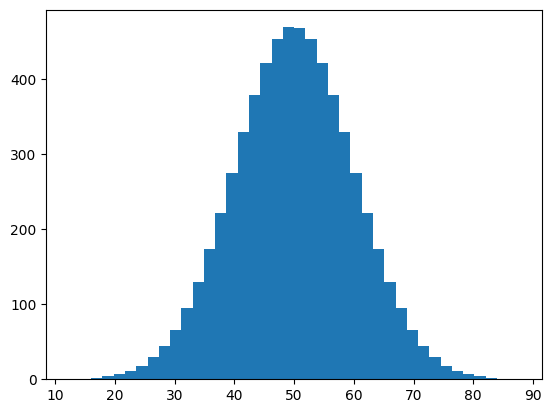

In [ ]:
plt.hist(si_list, bins=40)
plt.show()
# plt.xlim(0, 0.10)